In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt
import json
import random
import shutil
import torch, torchvision
import torchvision.transforms as T

In [15]:
print(torch.__version__, torch.cuda.is_available())
torch.set_grad_enabled(False);

# CLASSES = ['N/A', 'rebar', 'crack', 'spall']
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

1.8.1+cu111 True


In [59]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs, threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas_to_keep, bboxes_scaled


import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [20]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /home/user/.cache/torch/hub/facebookresearch_detr_master


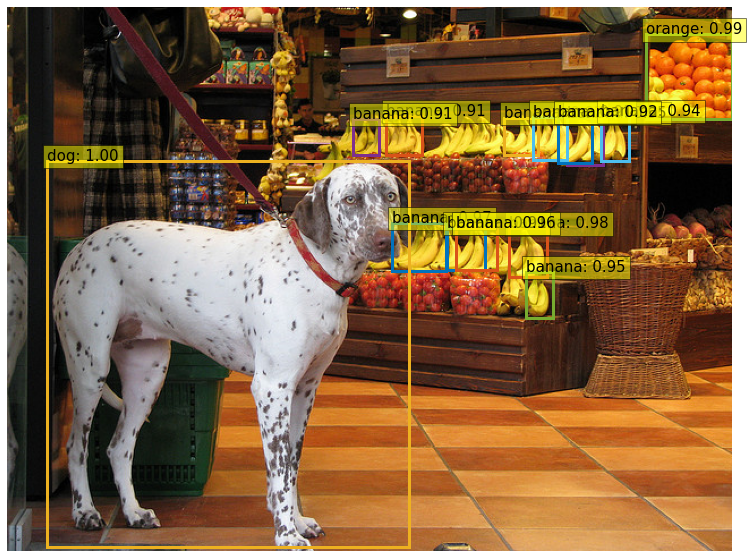

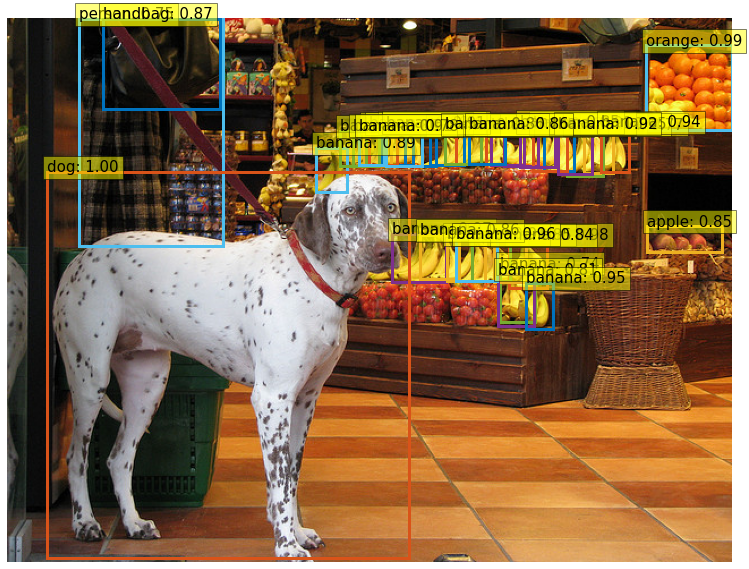

In [21]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)
for threshold in [0.9, 0.7]:
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)
    plot_results(im, probas_to_keep, bboxes_scaled)

In [22]:
!ls


annotations  capstone.ipynb  finetune-detr.ipynb  images  masks  train	val


In [26]:
%mkdir /media/App/tsai/capstone/content
%cd /media/App/tsai/capstone/content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/media/App/tsai/capstone/content
Cloning into 'detr'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 284.62 KiB | 1.38 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/media/App/tsai/capstone/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


In [27]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint, 'detr-r50_no-class-head.pth')

In [28]:
first_class_index = 1

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
rebar crack spall
Super-categories: {''}
showing validation file /media/App/tsai/capstone/train/0743.jpg


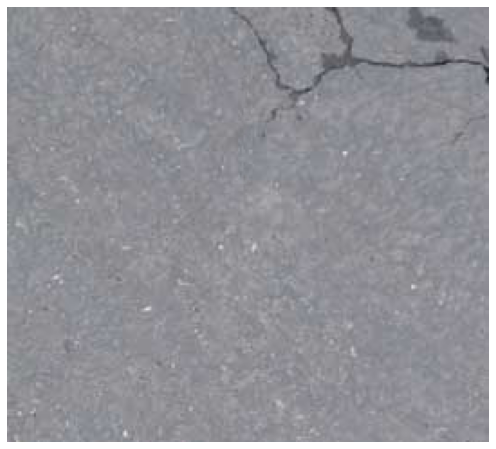

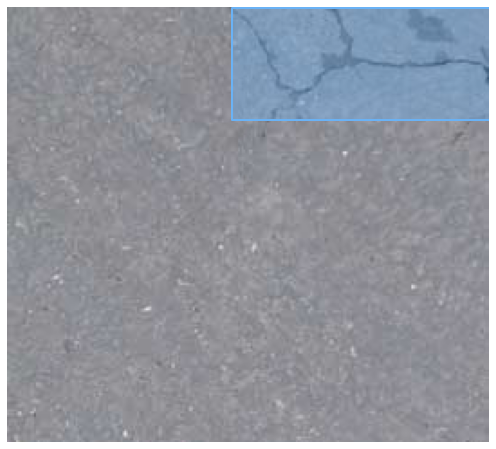

In [31]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

dataDir = '/media/App/tsai/capstone/annotations'
annfile = os.path.join(dataDir, 'custom_train.json')
coco = COCO(annfile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(f'COCO categories: \n{" ".join(nms)}')
nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['rebar', 'crack', 'spall']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [0])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(f'showing validation file {img["file_name"]}')
I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox = True)

In [32]:
assert(first_class_index in [0, 1])

if first_class_index == 0:
    num_classes = 3
    finetuned_classes = ['rebar', 'crack', 'spall']
else:

    # There are 3 classes, with id 1,2,3
    #
    # However, DETR assumes that indexing starts with 0, as in computer science,
    # so there is a dummy class with ID 0.
    # Caveat: this dummy class is not the `no_object` class reserved by DETR.
    num_classes = 4
    finetuned_classes = ['N/A', 'rebar', 'crack', 'spall']

    # The `no_object` class will be automatically reserved by DETR with ID equal
    # to `num_classes`, so ID 4 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 4
Fine-tuned classes: ['N/A', 'rebar', 'crack', 'spall']


In [34]:
%cd /media/App/tsai/capstone/content/detr

/media/App/tsai/capstone/content/detr


In [39]:
!python main.py \
    --dataset_file "custom" \
    --coco_path "/media/App/tsai/capstone/" \
    --output_dir "outputs" \
    --resume "detr-r50_no-class-head.pth" \
    --num_classes  $num_classes \
    --epochs 100

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: has uncommited changes, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=100, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=4, dataset_file='custom', coco_path='/media/App/tsai/capstone/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
number of params: 41280009
loading annotations into memory...
Done (t=0.00

Test:  [143/144]  eta: 0:00:00  class_error: 100.00  loss: 7.7727 (11.2568)  loss_ce: 0.3570 (0.4561)  loss_bbox: 0.3165 (0.5121)  loss_giou: 0.6371 (0.9068)  loss_ce_0: 0.4180 (0.4928)  loss_bbox_0: 0.3612 (0.5813)  loss_giou_0: 0.4939 (0.8808)  loss_ce_1: 0.4001 (0.4866)  loss_bbox_1: 0.3347 (0.5451)  loss_giou_1: 0.5564 (0.8411)  loss_ce_2: 0.4161 (0.4858)  loss_bbox_2: 0.3143 (0.4991)  loss_giou_2: 0.5451 (0.8631)  loss_ce_3: 0.3850 (0.4697)  loss_bbox_3: 0.3362 (0.5050)  loss_giou_3: 0.5877 (0.8863)  loss_ce_4: 0.3788 (0.4621)  loss_bbox_4: 0.3231 (0.4979)  loss_giou_4: 0.5337 (0.8851)  loss_ce_unscaled: 0.3570 (0.4561)  class_error_unscaled: 100.0000 (88.5899)  loss_bbox_unscaled: 0.0633 (0.1024)  loss_giou_unscaled: 0.3185 (0.4534)  cardinality_error_unscaled: 1.5000 (2.3507)  loss_ce_0_unscaled: 0.4180 (0.4928)  loss_bbox_0_unscaled: 0.0722 (0.1163)  loss_giou_0_unscaled: 0.2470 (0.4404)  cardinality_error_0_unscaled: 1.5000 (1.6944)  loss_ce_1_unscaled: 0.4001 (0.4866)  loss_b

Test:  [  0/144]  eta: 0:01:03  class_error: 100.00  loss: 7.8560 (7.8560)  loss_ce: 0.2951 (0.2951)  loss_bbox: 0.4410 (0.4410)  loss_giou: 0.3565 (0.3565)  loss_ce_0: 0.3523 (0.3523)  loss_bbox_0: 0.7756 (0.7756)  loss_giou_0: 0.6025 (0.6025)  loss_ce_1: 0.3404 (0.3404)  loss_bbox_1: 0.7069 (0.7069)  loss_giou_1: 0.4149 (0.4149)  loss_ce_2: 0.2845 (0.2845)  loss_bbox_2: 0.5246 (0.5246)  loss_giou_2: 0.4079 (0.4079)  loss_ce_3: 0.2851 (0.2851)  loss_bbox_3: 0.4990 (0.4990)  loss_giou_3: 0.2930 (0.2930)  loss_ce_4: 0.2963 (0.2963)  loss_bbox_4: 0.5885 (0.5885)  loss_giou_4: 0.3919 (0.3919)  loss_ce_unscaled: 0.2951 (0.2951)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0882 (0.0882)  loss_giou_unscaled: 0.1782 (0.1782)  cardinality_error_unscaled: 1.5000 (1.5000)  loss_ce_0_unscaled: 0.3523 (0.3523)  loss_bbox_0_unscaled: 0.1551 (0.1551)  loss_giou_0_unscaled: 0.3012 (0.3012)  cardinality_error_0_unscaled: 1.0000 (1.0000)  loss_ce_1_unscaled: 0.3404 (0.3404)  loss_b

Epoch: [2]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 66.67  loss: 8.5234 (10.1845)  loss_ce: 0.2612 (0.3430)  loss_bbox: 0.3243 (0.4778)  loss_giou: 0.7927 (0.8512)  loss_ce_0: 0.3200 (0.4051)  loss_bbox_0: 0.2779 (0.5302)  loss_giou_0: 0.8363 (0.8566)  loss_ce_1: 0.3083 (0.3876)  loss_bbox_1: 0.2892 (0.4916)  loss_giou_1: 0.7566 (0.8312)  loss_ce_2: 0.3048 (0.3725)  loss_bbox_2: 0.2771 (0.4670)  loss_giou_2: 0.7783 (0.8394)  loss_ce_3: 0.2698 (0.3524)  loss_bbox_3: 0.3275 (0.4654)  loss_giou_3: 0.8413 (0.8450)  loss_ce_4: 0.2547 (0.3445)  loss_bbox_4: 0.3195 (0.4722)  loss_giou_4: 0.8331 (0.8518)  loss_ce_unscaled: 0.2612 (0.3430)  class_error_unscaled: 33.3333 (54.8757)  loss_bbox_unscaled: 0.0649 (0.0956)  loss_giou_unscaled: 0.3964 (0.4256)  cardinality_error_unscaled: 1.5000 (1.6028)  loss_ce_0_unscaled: 0.3200 (0.4051)  loss_bbox_0_unscaled: 0.0556 (0.1060)  loss_giou_0_unscaled: 0.4181 (0.4283)  cardinality_error_0_unscaled: 2.5000 (1.8337)  loss_ce_1_unscaled: 0.3083

Test: Total time: 0:00:16 (0.1142 s / it)
Averaged stats: class_error: 50.00  loss: 8.8242 (10.1160)  loss_ce: 0.2872 (0.3272)  loss_bbox: 0.4121 (0.4420)  loss_giou: 0.7004 (0.8837)  loss_ce_0: 0.3491 (0.4046)  loss_bbox_0: 0.3195 (0.4698)  loss_giou_0: 0.6804 (0.8701)  loss_ce_1: 0.3154 (0.3941)  loss_bbox_1: 0.4074 (0.4675)  loss_giou_1: 0.6105 (0.8613)  loss_ce_2: 0.2950 (0.3670)  loss_bbox_2: 0.3386 (0.4449)  loss_giou_2: 0.6444 (0.8548)  loss_ce_3: 0.2698 (0.3405)  loss_bbox_3: 0.3230 (0.4455)  loss_giou_3: 0.7061 (0.8809)  loss_ce_4: 0.3047 (0.3311)  loss_bbox_4: 0.3052 (0.4457)  loss_giou_4: 0.5560 (0.8851)  loss_ce_unscaled: 0.2872 (0.3272)  class_error_unscaled: 50.0000 (46.5002)  loss_bbox_unscaled: 0.0824 (0.0884)  loss_giou_unscaled: 0.3502 (0.4419)  cardinality_error_unscaled: 1.5000 (2.1458)  loss_ce_0_unscaled: 0.3491 (0.4046)  loss_bbox_0_unscaled: 0.0639 (0.0940)  loss_giou_0_unscaled: 0.3402 (0.4351)  cardinality_error_0_unscaled: 2.5000 (2.8160)  loss_ce_1_unscaled:

Test:  [100/144]  eta: 0:00:05  class_error: 50.00  loss: 11.6667 (10.3319)  loss_ce: 0.3500 (0.3496)  loss_bbox: 0.4112 (0.4625)  loss_giou: 0.8023 (0.8992)  loss_ce_0: 0.3458 (0.3767)  loss_bbox_0: 0.5263 (0.5132)  loss_giou_0: 0.9089 (0.9043)  loss_ce_1: 0.3686 (0.3638)  loss_bbox_1: 0.4604 (0.4856)  loss_giou_1: 0.9199 (0.8726)  loss_ce_2: 0.3496 (0.3505)  loss_bbox_2: 0.4629 (0.4940)  loss_giou_2: 0.8051 (0.8655)  loss_ce_3: 0.3422 (0.3440)  loss_bbox_3: 0.5109 (0.4740)  loss_giou_3: 0.7924 (0.8808)  loss_ce_4: 0.3531 (0.3471)  loss_bbox_4: 0.4014 (0.4614)  loss_giou_4: 0.8012 (0.8870)  loss_ce_unscaled: 0.3500 (0.3496)  class_error_unscaled: 66.6667 (59.0665)  loss_bbox_unscaled: 0.0822 (0.0925)  loss_giou_unscaled: 0.4011 (0.4496)  cardinality_error_unscaled: 1.0000 (0.9901)  loss_ce_0_unscaled: 0.3458 (0.3767)  loss_bbox_0_unscaled: 0.1053 (0.1026)  loss_giou_0_unscaled: 0.4544 (0.4522)  cardinality_error_0_unscaled: 1.5000 (1.6287)  loss_ce_1_unscaled: 0.3686 (0.3638)  loss_bb

Epoch: [4] Total time: 0:01:35 (0.2197 s / it)
Averaged stats: lr: 0.000100  class_error: 50.00  loss: 8.2706 (9.7606)  loss_ce: 0.2500 (0.3146)  loss_bbox: 0.3342 (0.4619)  loss_giou: 0.7772 (0.8442)  loss_ce_0: 0.2964 (0.3631)  loss_bbox_0: 0.3852 (0.4833)  loss_giou_0: 0.8584 (0.8523)  loss_ce_1: 0.2817 (0.3461)  loss_bbox_1: 0.3421 (0.4595)  loss_giou_1: 0.7988 (0.8257)  loss_ce_2: 0.2644 (0.3290)  loss_bbox_2: 0.3562 (0.4550)  loss_giou_2: 0.7641 (0.8258)  loss_ce_3: 0.2524 (0.3154)  loss_bbox_3: 0.3489 (0.4454)  loss_giou_3: 0.7505 (0.8345)  loss_ce_4: 0.2450 (0.3113)  loss_bbox_4: 0.3435 (0.4573)  loss_giou_4: 0.7467 (0.8363)  loss_ce_unscaled: 0.2500 (0.3146)  class_error_unscaled: 50.0000 (47.5279)  loss_bbox_unscaled: 0.0668 (0.0924)  loss_giou_unscaled: 0.3886 (0.4221)  cardinality_error_unscaled: 1.0000 (1.8764)  loss_ce_0_unscaled: 0.2964 (0.3631)  loss_bbox_0_unscaled: 0.0770 (0.0967)  loss_giou_0_unscaled: 0.4292 (0.4261)  cardinality_error_0_unscaled: 2.5000 (1.9688)  l

DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.753
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 7.5617 (9.4725)  loss_ce: 0.2162 (0.2671)  loss_bbox: 0.3585 (0.4348)  loss_giou: 0.6446 (0.8383)  loss_ce_0: 0.2650 (0.3393)  loss_bbox_0: 0.3622 (0.4323)  loss_giou_0: 0.6760 (0.8864)  loss_ce_1: 0.2721 (0.3228)  loss_bbox_1: 0.3083 (0.4593)  loss_giou_1: 0.4386 (0.8262)  loss_ce_2: 0.2095 (0.2888)  loss_bbox_2: 0.3971 (0.4524)  loss_giou_2: 0.5986 (0.8381)  loss_ce_3: 0.1922 (0.2765)  loss_bbox_3: 0.4521 (0.4445)  loss_giou_3: 0.5895 (0.8448)  loss_ce_4: 0.2090 (0.2671)  loss_bbox_4: 0.3678 (0.4230)  loss_giou_4: 0.6987 (0.8310)  loss_ce_unscaled: 0.2162 (0.2671)  class_error_unscaled: 33.3333 (34.3177)  loss_bbox_unscaled: 0.0717 (0.0870)  loss_giou_unscaled: 0.3223 (0.4191)  cardinality_error_unscaled: 1.5000 (1.9965)  loss_ce_0_unscaled: 0.2650 (0.3393)  loss_bbox_0_unscaled: 0.0724 (0.0865)  loss_giou_0_unscaled: 0.3380 (0.4432)  cardinality_error_0_unscaled: 3.0000 (3.2222)  loss_ce_1_unscaled: 0.2721 (0.3228)  loss_bbox_

Test:  [  0/144]  eta: 0:01:03  class_error: 0.00  loss: 4.8485 (4.8485)  loss_ce: 0.0975 (0.0975)  loss_bbox: 0.4528 (0.4528)  loss_giou: 0.3074 (0.3074)  loss_ce_0: 0.1863 (0.1863)  loss_bbox_0: 0.1930 (0.1930)  loss_giou_0: 0.2369 (0.2369)  loss_ce_1: 0.1284 (0.1284)  loss_bbox_1: 0.4219 (0.4219)  loss_giou_1: 0.2985 (0.2985)  loss_ce_2: 0.1097 (0.1097)  loss_bbox_2: 0.4161 (0.4161)  loss_giou_2: 0.2607 (0.2607)  loss_ce_3: 0.1000 (0.1000)  loss_bbox_3: 0.4467 (0.4467)  loss_giou_3: 0.3481 (0.3481)  loss_ce_4: 0.1006 (0.1006)  loss_bbox_4: 0.4430 (0.4430)  loss_giou_4: 0.3010 (0.3010)  loss_ce_unscaled: 0.0975 (0.0975)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0906 (0.0906)  loss_giou_unscaled: 0.1537 (0.1537)  cardinality_error_unscaled: 0.5000 (0.5000)  loss_ce_0_unscaled: 0.1863 (0.1863)  loss_bbox_0_unscaled: 0.0386 (0.0386)  loss_giou_0_unscaled: 0.1185 (0.1185)  cardinality_error_0_unscaled: 4.0000 (4.0000)  loss_ce_1_unscaled: 0.1284 (0.1284)  loss_bbox_1_

Epoch: [7]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 33.33  loss: 10.1055 (9.2141)  loss_ce: 0.2934 (0.2737)  loss_bbox: 0.4912 (0.4249)  loss_giou: 0.8744 (0.8204)  loss_ce_0: 0.3404 (0.3401)  loss_bbox_0: 0.4683 (0.4554)  loss_giou_0: 0.8250 (0.8409)  loss_ce_1: 0.3664 (0.3150)  loss_bbox_1: 0.4230 (0.4178)  loss_giou_1: 0.8553 (0.8023)  loss_ce_2: 0.3343 (0.2927)  loss_bbox_2: 0.4407 (0.4160)  loss_giou_2: 0.8534 (0.8111)  loss_ce_3: 0.2992 (0.2868)  loss_bbox_3: 0.4563 (0.4117)  loss_giou_3: 0.8552 (0.8028)  loss_ce_4: 0.3101 (0.2778)  loss_bbox_4: 0.4415 (0.4133)  loss_giou_4: 0.8320 (0.8113)  loss_ce_unscaled: 0.2934 (0.2737)  class_error_unscaled: 50.0000 (42.5684)  loss_bbox_unscaled: 0.0982 (0.0850)  loss_giou_unscaled: 0.4372 (0.4102)  cardinality_error_unscaled: 1.5000 (1.3106)  loss_ce_0_unscaled: 0.3404 (0.3401)  loss_bbox_0_unscaled: 0.0937 (0.0911)  loss_giou_0_unscaled: 0.4125 (0.4205)  cardinality_error_0_unscaled: 2.0000 (2.0346)  loss_ce_1_unscaled: 0.3664

Test: Total time: 0:00:16 (0.1140 s / it)
Averaged stats: class_error: 0.00  loss: 7.4175 (9.3978)  loss_ce: 0.1776 (0.2710)  loss_bbox: 0.3952 (0.4558)  loss_giou: 0.6921 (0.8518)  loss_ce_0: 0.2699 (0.3297)  loss_bbox_0: 0.3112 (0.4444)  loss_giou_0: 0.4596 (0.8306)  loss_ce_1: 0.2455 (0.3142)  loss_bbox_1: 0.3325 (0.4334)  loss_giou_1: 0.4309 (0.8167)  loss_ce_2: 0.2374 (0.2972)  loss_bbox_2: 0.3315 (0.4461)  loss_giou_2: 0.5438 (0.8061)  loss_ce_3: 0.1950 (0.2841)  loss_bbox_3: 0.3827 (0.4583)  loss_giou_3: 0.6032 (0.8160)  loss_ce_4: 0.2153 (0.2817)  loss_bbox_4: 0.3947 (0.4343)  loss_giou_4: 0.7002 (0.8265)  loss_ce_unscaled: 0.1776 (0.2710)  class_error_unscaled: 0.0000 (36.6871)  loss_bbox_unscaled: 0.0790 (0.0912)  loss_giou_unscaled: 0.3460 (0.4259)  cardinality_error_unscaled: 2.5000 (2.2049)  loss_ce_0_unscaled: 0.2699 (0.3297)  loss_bbox_0_unscaled: 0.0622 (0.0889)  loss_giou_0_unscaled: 0.2298 (0.4153)  cardinality_error_0_unscaled: 3.0000 (3.2743)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.3448 (8.7709)  loss_ce: 0.2555 (0.2415)  loss_bbox: 0.4040 (0.4125)  loss_giou: 0.5554 (0.8196)  loss_ce_0: 0.2774 (0.2995)  loss_bbox_0: 0.4396 (0.3800)  loss_giou_0: 0.8108 (0.7700)  loss_ce_1: 0.2625 (0.2830)  loss_bbox_1: 0.3616 (0.3853)  loss_giou_1: 0.5968 (0.7665)  loss_ce_2: 0.2728 (0.2544)  loss_bbox_2: 0.4710 (0.4150)  loss_giou_2: 0.7555 (0.8030)  loss_ce_3: 0.2854 (0.2511)  loss_bbox_3: 0.3849 (0.4059)  loss_giou_3: 0.5606 (0.8034)  loss_ce_4: 0.1975 (0.2465)  loss_bbox_4: 0.4117 (0.4136)  loss_giou_4: 0.5989 (0.8202)  loss_ce_unscaled: 0.2555 (0.2415)  class_error_unscaled: 50.0000 (39.2562)  loss_bbox_unscaled: 0.0808 (0.0825)  loss_giou_unscaled: 0.2777 (0.4098)  cardinality_error_unscaled: 1.5000 (1.3465)  loss_ce_0_unscaled: 0.2774 (0.2995)  loss_bbox_0_unscaled: 0.0879 (0.0760)  loss_giou_0_unscaled: 0.4054 (0.3850)  cardinality_error_0_unscaled: 1.5000 (1.8861)  loss_ce_1_unscaled: 0.2625 (0.2830)  loss_bbox_

Epoch: [9] Total time: 0:01:35 (0.2196 s / it)
Averaged stats: lr: 0.000100  class_error: 50.00  loss: 7.6330 (8.8956)  loss_ce: 0.1719 (0.2476)  loss_bbox: 0.3563 (0.3999)  loss_giou: 0.8186 (0.8185)  loss_ce_0: 0.2127 (0.3053)  loss_bbox_0: 0.4199 (0.4205)  loss_giou_0: 0.6951 (0.8166)  loss_ce_1: 0.2210 (0.2947)  loss_bbox_1: 0.4010 (0.4062)  loss_giou_1: 0.6942 (0.8011)  loss_ce_2: 0.1884 (0.2671)  loss_bbox_2: 0.3395 (0.3966)  loss_giou_2: 0.8417 (0.8097)  loss_ce_3: 0.2068 (0.2546)  loss_bbox_3: 0.3663 (0.3988)  loss_giou_3: 0.7693 (0.8080)  loss_ce_4: 0.1856 (0.2518)  loss_bbox_4: 0.3796 (0.3931)  loss_giou_4: 0.8137 (0.8055)  loss_ce_unscaled: 0.1719 (0.2476)  class_error_unscaled: 25.0000 (37.1901)  loss_bbox_unscaled: 0.0713 (0.0800)  loss_giou_unscaled: 0.4093 (0.4093)  cardinality_error_unscaled: 1.0000 (1.2252)  loss_ce_0_unscaled: 0.2127 (0.3053)  loss_bbox_0_unscaled: 0.0840 (0.0841)  loss_giou_0_unscaled: 0.3476 (0.4083)  cardinality_error_0_unscaled: 1.5000 (1.9758)  l

Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Test:  [143/144]  eta: 0:00:00  class_error: 50.00  loss: 7.3152 (8.8990)  loss_ce: 0.2234 (0.2495)  loss_bbox: 0.2923 (0.3783)  loss_giou: 0.5219 (0.8043)  loss_ce_0: 0.2509 (0.3185)  loss_bbox_0: 0.3678 (0.4484)  loss_giou_0: 0.7036 (0.8968)  loss_ce_1: 0.3128 (0.3082)  loss_bbox_1: 0.3309 (0.3766)  loss_giou_1: 0.6572 (0.7992)  loss_ce_2: 0.2567 (0.2822)  loss_bbox_2: 0.2868 (0.3655)  loss_giou_2: 0.5784 (0.7944)  loss_ce_3: 0.1943 (0.2736)  loss_bbox_3: 0.3099 (0.3668)  loss_giou_3: 0.5672 (0.8048)  loss_ce_4: 0.2185 (0.2552)  loss_bbox_4: 0.3109 (0.3711)  loss_giou_4: 0.5464 (0.8057)  loss_ce_unscaled: 0.2234 (0.2495)  class_error_unscaled: 33.3333 (39.5442)  loss_bbox_unscaled: 0.0585 (0.0757)  loss_giou_unscaled: 0.2610 (0.4021)  cardinality_error_unscaled: 0.5000 (0.7188)  loss_ce_0_unscaled: 0.2509 (0.3185)  loss_bbox_0_unscaled: 0.0736 (0.0897)  loss_giou_0_unscaled: 0.3518 (0.4484)  cardinality_error_0_unscaled: 1.5000 (1.9826)  loss_ce_1_unscaled: 0.3128 (0.3082)  loss_bbox

Test:  [  0/144]  eta: 0:01:03  class_error: 50.00  loss: 4.4294 (4.4294)  loss_ce: 0.2257 (0.2257)  loss_bbox: 0.2412 (0.2412)  loss_giou: 0.1894 (0.1894)  loss_ce_0: 0.0750 (0.0750)  loss_bbox_0: 0.4913 (0.4913)  loss_giou_0: 0.2956 (0.2956)  loss_ce_1: 0.0664 (0.0664)  loss_bbox_1: 0.4260 (0.4260)  loss_giou_1: 0.2437 (0.2437)  loss_ce_2: 0.0607 (0.0607)  loss_bbox_2: 0.5587 (0.5587)  loss_giou_2: 0.3041 (0.3041)  loss_ce_3: 0.2353 (0.2353)  loss_bbox_3: 0.2666 (0.2666)  loss_giou_3: 0.1675 (0.1675)  loss_ce_4: 0.2249 (0.2249)  loss_bbox_4: 0.2090 (0.2090)  loss_giou_4: 0.1483 (0.1483)  loss_ce_unscaled: 0.2257 (0.2257)  class_error_unscaled: 50.0000 (50.0000)  loss_bbox_unscaled: 0.0482 (0.0482)  loss_giou_unscaled: 0.0947 (0.0947)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0750 (0.0750)  loss_bbox_0_unscaled: 0.0983 (0.0983)  loss_giou_0_unscaled: 0.1478 (0.1478)  cardinality_error_0_unscaled: 0.5000 (0.5000)  loss_ce_1_unscaled: 0.0664 (0.0664)  loss_bbox

Epoch: [12]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 7.3519 (8.5356)  loss_ce: 0.1896 (0.2511)  loss_bbox: 0.2950 (0.3798)  loss_giou: 0.5601 (0.7619)  loss_ce_0: 0.2525 (0.2974)  loss_bbox_0: 0.2896 (0.4127)  loss_giou_0: 0.6521 (0.7969)  loss_ce_1: 0.2364 (0.2774)  loss_bbox_1: 0.2764 (0.3857)  loss_giou_1: 0.6487 (0.7777)  loss_ce_2: 0.2137 (0.2686)  loss_bbox_2: 0.2996 (0.3768)  loss_giou_2: 0.5892 (0.7759)  loss_ce_3: 0.1960 (0.2594)  loss_bbox_3: 0.2417 (0.3679)  loss_giou_3: 0.4972 (0.7626)  loss_ce_4: 0.1880 (0.2520)  loss_bbox_4: 0.2991 (0.3742)  loss_giou_4: 0.6368 (0.7576)  loss_ce_unscaled: 0.1896 (0.2511)  class_error_unscaled: 33.3333 (37.6393)  loss_bbox_unscaled: 0.0590 (0.0760)  loss_giou_unscaled: 0.2800 (0.3809)  cardinality_error_unscaled: 1.0000 (1.1963)  loss_ce_0_unscaled: 0.2525 (0.2974)  loss_bbox_0_unscaled: 0.0579 (0.0825)  loss_giou_0_unscaled: 0.3260 (0.3985)  cardinality_error_0_unscaled: 1.5000 (1.8776)  loss_ce_1_unscaled: 0.2364 

Test: Total time: 0:00:16 (0.1127 s / it)
Averaged stats: class_error: 0.00  loss: 5.8575 (8.1796)  loss_ce: 0.2173 (0.2551)  loss_bbox: 0.2328 (0.3270)  loss_giou: 0.5189 (0.7583)  loss_ce_0: 0.2420 (0.3037)  loss_bbox_0: 0.2991 (0.3752)  loss_giou_0: 0.4207 (0.7655)  loss_ce_1: 0.2529 (0.2970)  loss_bbox_1: 0.2944 (0.3503)  loss_giou_1: 0.3684 (0.7389)  loss_ce_2: 0.2487 (0.2734)  loss_bbox_2: 0.2284 (0.3418)  loss_giou_2: 0.4189 (0.7438)  loss_ce_3: 0.2403 (0.2630)  loss_bbox_3: 0.2333 (0.3280)  loss_giou_3: 0.3526 (0.7406)  loss_ce_4: 0.2135 (0.2538)  loss_bbox_4: 0.2169 (0.3225)  loss_giou_4: 0.4491 (0.7416)  loss_ce_unscaled: 0.2173 (0.2551)  class_error_unscaled: 33.3333 (40.5715)  loss_bbox_unscaled: 0.0466 (0.0654)  loss_giou_unscaled: 0.2595 (0.3792)  cardinality_error_unscaled: 1.0000 (1.1042)  loss_ce_0_unscaled: 0.2420 (0.3037)  loss_bbox_0_unscaled: 0.0598 (0.0750)  loss_giou_0_unscaled: 0.2104 (0.3827)  cardinality_error_0_unscaled: 2.0000 (2.4653)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 9.1703 (8.4038)  loss_ce: 0.1477 (0.2069)  loss_bbox: 0.4334 (0.3844)  loss_giou: 0.7790 (0.7910)  loss_ce_0: 0.2372 (0.2579)  loss_bbox_0: 0.4060 (0.3971)  loss_giou_0: 0.7709 (0.7852)  loss_ce_1: 0.1866 (0.2322)  loss_bbox_1: 0.4704 (0.4037)  loss_giou_1: 0.8180 (0.7968)  loss_ce_2: 0.1826 (0.2123)  loss_bbox_2: 0.4917 (0.3859)  loss_giou_2: 0.9131 (0.7935)  loss_ce_3: 0.1712 (0.2061)  loss_bbox_3: 0.4759 (0.3875)  loss_giou_3: 0.8472 (0.7794)  loss_ce_4: 0.1585 (0.2030)  loss_bbox_4: 0.4507 (0.3864)  loss_giou_4: 0.8087 (0.7946)  loss_ce_unscaled: 0.1477 (0.2069)  class_error_unscaled: 33.3333 (31.7621)  loss_bbox_unscaled: 0.0867 (0.0769)  loss_giou_unscaled: 0.3895 (0.3955)  cardinality_error_unscaled: 1.5000 (1.2772)  loss_ce_0_unscaled: 0.2372 (0.2579)  loss_bbox_0_unscaled: 0.0812 (0.0794)  loss_giou_0_unscaled: 0.3855 (0.3926)  cardinality_error_0_unscaled: 3.0000 (2.7970)  loss_ce_1_unscaled: 0.1866 (0.2322)  loss_bbox_

Epoch: [14] Total time: 0:01:35 (0.2200 s / it)
Averaged stats: lr: 0.000100  class_error: 80.00  loss: 7.0391 (8.5186)  loss_ce: 0.1599 (0.2283)  loss_bbox: 0.2762 (0.3681)  loss_giou: 0.8221 (0.7970)  loss_ce_0: 0.2484 (0.2754)  loss_bbox_0: 0.4176 (0.4136)  loss_giou_0: 0.9585 (0.8189)  loss_ce_1: 0.2423 (0.2539)  loss_bbox_1: 0.3518 (0.3795)  loss_giou_1: 0.8704 (0.8040)  loss_ce_2: 0.1926 (0.2408)  loss_bbox_2: 0.3167 (0.3712)  loss_giou_2: 0.7480 (0.7901)  loss_ce_3: 0.1851 (0.2381)  loss_bbox_3: 0.3420 (0.3629)  loss_giou_3: 0.8103 (0.7938)  loss_ce_4: 0.1633 (0.2295)  loss_bbox_4: 0.3121 (0.3654)  loss_giou_4: 0.8227 (0.7880)  loss_ce_unscaled: 0.1599 (0.2283)  class_error_unscaled: 33.3333 (34.3871)  loss_bbox_unscaled: 0.0552 (0.0736)  loss_giou_unscaled: 0.4111 (0.3985)  cardinality_error_unscaled: 1.0000 (1.1501)  loss_ce_0_unscaled: 0.2484 (0.2754)  loss_bbox_0_unscaled: 0.0835 (0.0827)  loss_giou_0_unscaled: 0.4792 (0.4094)  cardinality_error_0_unscaled: 2.0000 (2.2471)  

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.6927 (8.0395)  loss_ce: 0.1171 (0.2172)  loss_bbox: 0.3024 (0.3261)  loss_giou: 0.5187 (0.7884)  loss_ce_0: 0.1888 (0.2615)  loss_bbox_0: 0.2866 (0.3606)  loss_giou_0: 0.3746 (0.7656)  loss_ce_1: 0.1906 (0.2451)  loss_bbox_1: 0.2976 (0.3381)  loss_giou_1: 0.3899 (0.7575)  loss_ce_2: 0.1790 (0.2304)  loss_bbox_2: 0.2889 (0.3326)  loss_giou_2: 0.3824 (0.7613)  loss_ce_3: 0.1840 (0.2192)  loss_bbox_3: 0.2914 (0.3279)  loss_giou_3: 0.5098 (0.7902)  loss_ce_4: 0.1598 (0.2128)  loss_bbox_4: 0.2784 (0.3269)  loss_giou_4: 0.4559 (0.7780)  loss_ce_unscaled: 0.1171 (0.2172)  class_error_unscaled: 33.3333 (31.3616)  loss_bbox_unscaled: 0.0605 (0.0652)  loss_giou_unscaled: 0.2593 (0.3942)  cardinality_error_unscaled: 1.0000 (1.1910)  loss_ce_0_unscaled: 0.1888 (0.2615)  loss_bbox_0_unscaled: 0.0573 (0.0721)  loss_giou_0_unscaled: 0.1873 (0.3828)  cardinality_error_0_unscaled: 2.0000 (3.1076)  loss_ce_1_unscaled: 0.1906 (0.2451)  loss_bbox_

Test:  [  0/144]  eta: 0:01:05  class_error: 0.00  loss: 4.7287 (4.7287)  loss_ce: 0.0837 (0.0837)  loss_bbox: 0.4038 (0.4038)  loss_giou: 0.2798 (0.2798)  loss_ce_0: 0.0762 (0.0762)  loss_bbox_0: 0.4928 (0.4928)  loss_giou_0: 0.3452 (0.3452)  loss_ce_1: 0.0798 (0.0798)  loss_bbox_1: 0.4145 (0.4145)  loss_giou_1: 0.3173 (0.3173)  loss_ce_2: 0.0820 (0.0820)  loss_bbox_2: 0.3861 (0.3861)  loss_giou_2: 0.2703 (0.2703)  loss_ce_3: 0.0889 (0.0889)  loss_bbox_3: 0.3914 (0.3914)  loss_giou_3: 0.2705 (0.2705)  loss_ce_4: 0.0749 (0.0749)  loss_bbox_4: 0.4005 (0.4005)  loss_giou_4: 0.2708 (0.2708)  loss_ce_unscaled: 0.0837 (0.0837)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0808 (0.0808)  loss_giou_unscaled: 0.1399 (0.1399)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0762 (0.0762)  loss_bbox_0_unscaled: 0.0986 (0.0986)  loss_giou_0_unscaled: 0.1726 (0.1726)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0798 (0.0798)  loss_bbox_1_

Epoch: [17]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 20.00  loss: 9.2383 (8.2897)  loss_ce: 0.2835 (0.2262)  loss_bbox: 0.4088 (0.3714)  loss_giou: 0.9069 (0.7661)  loss_ce_0: 0.3308 (0.2781)  loss_bbox_0: 0.4440 (0.3958)  loss_giou_0: 0.8796 (0.7795)  loss_ce_1: 0.2976 (0.2567)  loss_bbox_1: 0.3799 (0.3680)  loss_giou_1: 0.9156 (0.7628)  loss_ce_2: 0.2668 (0.2444)  loss_bbox_2: 0.3814 (0.3586)  loss_giou_2: 0.9439 (0.7599)  loss_ce_3: 0.2662 (0.2288)  loss_bbox_3: 0.3711 (0.3635)  loss_giou_3: 0.9387 (0.7694)  loss_ce_4: 0.3011 (0.2274)  loss_bbox_4: 0.3694 (0.3670)  loss_giou_4: 0.9034 (0.7659)  loss_ce_unscaled: 0.2835 (0.2262)  class_error_unscaled: 33.3333 (33.7360)  loss_bbox_unscaled: 0.0818 (0.0743)  loss_giou_unscaled: 0.4534 (0.3830)  cardinality_error_unscaled: 1.0000 (1.0127)  loss_ce_0_unscaled: 0.3308 (0.2781)  loss_bbox_0_unscaled: 0.0888 (0.0792)  loss_giou_0_unscaled: 0.4398 (0.3898)  cardinality_error_0_unscaled: 1.5000 (1.8222)  loss_ce_1_unscaled: 0.2976

Test: Total time: 0:00:16 (0.1133 s / it)
Averaged stats: class_error: 50.00  loss: 5.5646 (8.3373)  loss_ce: 0.1861 (0.2248)  loss_bbox: 0.2085 (0.3629)  loss_giou: 0.3989 (0.7954)  loss_ce_0: 0.1798 (0.2510)  loss_bbox_0: 0.2691 (0.4028)  loss_giou_0: 0.4305 (0.7909)  loss_ce_1: 0.1644 (0.2227)  loss_bbox_1: 0.2458 (0.3740)  loss_giou_1: 0.4573 (0.7799)  loss_ce_2: 0.2210 (0.2287)  loss_bbox_2: 0.2297 (0.3660)  loss_giou_2: 0.4114 (0.7801)  loss_ce_3: 0.1871 (0.2149)  loss_bbox_3: 0.2376 (0.3796)  loss_giou_3: 0.4001 (0.7931)  loss_ce_4: 0.1772 (0.2131)  loss_bbox_4: 0.2295 (0.3706)  loss_giou_4: 0.3945 (0.7867)  loss_ce_unscaled: 0.1861 (0.2248)  class_error_unscaled: 33.3333 (34.8644)  loss_bbox_unscaled: 0.0417 (0.0726)  loss_giou_unscaled: 0.1994 (0.3977)  cardinality_error_unscaled: 0.5000 (0.8333)  loss_ce_0_unscaled: 0.1798 (0.2510)  loss_bbox_0_unscaled: 0.0538 (0.0806)  loss_giou_0_unscaled: 0.2152 (0.3954)  cardinality_error_0_unscaled: 1.5000 (1.9062)  loss_ce_1_unscaled: 

Test:  [100/144]  eta: 0:00:04  class_error: 0.00  loss: 8.7305 (8.5141)  loss_ce: 0.1731 (0.2247)  loss_bbox: 0.3551 (0.3871)  loss_giou: 0.7227 (0.8180)  loss_ce_0: 0.2206 (0.2769)  loss_bbox_0: 0.3604 (0.3683)  loss_giou_0: 0.7857 (0.8137)  loss_ce_1: 0.2006 (0.2415)  loss_bbox_1: 0.3831 (0.3565)  loss_giou_1: 0.6753 (0.7749)  loss_ce_2: 0.2113 (0.2326)  loss_bbox_2: 0.4035 (0.3826)  loss_giou_2: 0.7425 (0.8104)  loss_ce_3: 0.1828 (0.2210)  loss_bbox_3: 0.4335 (0.3718)  loss_giou_3: 0.7448 (0.8113)  loss_ce_4: 0.1630 (0.2183)  loss_bbox_4: 0.4543 (0.3870)  loss_giou_4: 0.7238 (0.8174)  loss_ce_unscaled: 0.1731 (0.2247)  class_error_unscaled: 33.3333 (35.9653)  loss_bbox_unscaled: 0.0710 (0.0774)  loss_giou_unscaled: 0.3614 (0.4090)  cardinality_error_unscaled: 0.5000 (0.6980)  loss_ce_0_unscaled: 0.2206 (0.2769)  loss_bbox_0_unscaled: 0.0721 (0.0737)  loss_giou_0_unscaled: 0.3928 (0.4068)  cardinality_error_0_unscaled: 0.5000 (1.2129)  loss_ce_1_unscaled: 0.2006 (0.2415)  loss_bbox_

Epoch: [19] Total time: 0:01:35 (0.2213 s / it)
Averaged stats: lr: 0.000100  class_error: 66.67  loss: 7.8375 (8.2340)  loss_ce: 0.2009 (0.2209)  loss_bbox: 0.2812 (0.3514)  loss_giou: 0.8412 (0.7827)  loss_ce_0: 0.2296 (0.2695)  loss_bbox_0: 0.3833 (0.3804)  loss_giou_0: 0.8387 (0.7860)  loss_ce_1: 0.2253 (0.2414)  loss_bbox_1: 0.3179 (0.3718)  loss_giou_1: 0.8034 (0.7690)  loss_ce_2: 0.1618 (0.2292)  loss_bbox_2: 0.4362 (0.3630)  loss_giou_2: 0.7892 (0.7727)  loss_ce_3: 0.1538 (0.2246)  loss_bbox_3: 0.3661 (0.3511)  loss_giou_3: 0.7954 (0.7732)  loss_ce_4: 0.1450 (0.2217)  loss_bbox_4: 0.3185 (0.3523)  loss_giou_4: 0.8067 (0.7729)  loss_ce_unscaled: 0.2009 (0.2209)  class_error_unscaled: 33.3333 (34.5181)  loss_bbox_unscaled: 0.0562 (0.0703)  loss_giou_unscaled: 0.4206 (0.3913)  cardinality_error_unscaled: 0.5000 (1.1928)  loss_ce_0_unscaled: 0.2296 (0.2695)  loss_bbox_0_unscaled: 0.0767 (0.0761)  loss_giou_0_unscaled: 0.4193 (0.3930)  cardinality_error_0_unscaled: 1.0000 (1.9457)  

DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.6221 (8.1814)  loss_ce: 0.1092 (0.2072)  loss_bbox: 0.3380 (0.3674)  loss_giou: 0.5763 (0.7865)  loss_ce_0: 0.2329 (0.2591)  loss_bbox_0: 0.3032 (0.3718)  loss_giou_0: 0.5489 (0.7950)  loss_ce_1: 0.1876 (0.2429)  loss_bbox_1: 0.3106 (0.3548)  loss_giou_1: 0.4119 (0.7625)  loss_ce_2: 0.1792 (0.2241)  loss_bbox_2: 0.2886 (0.3597)  loss_giou_2: 0.4778 (0.7656)  loss_ce_3: 0.1880 (0.2106)  loss_bbox_3: 0.2789 (0.3552)  loss_giou_3: 0.4704 (0.7678)  loss_ce_4: 0.1139 (0.2065)  loss_bbox_4: 0.2889 (0.3612)  loss_giou_4: 0.5032 (0.7835)  loss_ce_unscaled: 0.1092 (0.2072)  class_error_unscaled: 0.0000 (29.5434)  loss_bbox_unscaled: 0.0676 (0.0735)  loss_giou_unscaled: 0.2882 (0.3932)  cardinality_error_unscaled: 1.0000 (0.8958)  loss_ce_0_unscaled: 0.2329 (0.2591)  loss_bbox_0_unscaled: 0.0606 (0.0744)  loss_giou_0_unscaled: 0.2745 (0.3975)  cardinality_error_0_unscaled: 2.0000 (2.6215)  loss_ce_1_unscaled: 0.1876 (0.2429)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:04  class_error: 0.00  loss: 2.6664 (2.6664)  loss_ce: 0.0488 (0.0488)  loss_bbox: 0.1606 (0.1606)  loss_giou: 0.1375 (0.1375)  loss_ce_0: 0.0662 (0.0662)  loss_bbox_0: 0.2870 (0.2870)  loss_giou_0: 0.1712 (0.1712)  loss_ce_1: 0.0550 (0.0550)  loss_bbox_1: 0.2478 (0.2478)  loss_giou_1: 0.1929 (0.1929)  loss_ce_2: 0.0569 (0.0569)  loss_bbox_2: 0.2809 (0.2809)  loss_giou_2: 0.1699 (0.1699)  loss_ce_3: 0.0615 (0.0615)  loss_bbox_3: 0.2306 (0.2306)  loss_giou_3: 0.1604 (0.1604)  loss_ce_4: 0.0528 (0.0528)  loss_bbox_4: 0.1656 (0.1656)  loss_giou_4: 0.1209 (0.1209)  loss_ce_unscaled: 0.0488 (0.0488)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0321 (0.0321)  loss_giou_unscaled: 0.0687 (0.0687)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0662 (0.0662)  loss_bbox_0_unscaled: 0.0574 (0.0574)  loss_giou_0_unscaled: 0.0856 (0.0856)  cardinality_error_0_unscaled: 0.5000 (0.5000)  loss_ce_1_unscaled: 0.0550 (0.0550)  loss_bbox_1_

Epoch: [22]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 33.33  loss: 5.4577 (7.7598)  loss_ce: 0.1602 (0.1920)  loss_bbox: 0.2768 (0.3348)  loss_giou: 0.4976 (0.7447)  loss_ce_0: 0.1858 (0.2324)  loss_bbox_0: 0.3023 (0.3724)  loss_giou_0: 0.5610 (0.7642)  loss_ce_1: 0.1680 (0.2144)  loss_bbox_1: 0.2962 (0.3471)  loss_giou_1: 0.5187 (0.7376)  loss_ce_2: 0.1515 (0.1991)  loss_bbox_2: 0.3290 (0.3383)  loss_giou_2: 0.5486 (0.7418)  loss_ce_3: 0.1658 (0.1922)  loss_bbox_3: 0.2939 (0.3348)  loss_giou_3: 0.4878 (0.7434)  loss_ce_4: 0.1734 (0.1914)  loss_bbox_4: 0.2867 (0.3345)  loss_giou_4: 0.4966 (0.7449)  loss_ce_unscaled: 0.1602 (0.1920)  class_error_unscaled: 25.0000 (28.7709)  loss_bbox_unscaled: 0.0554 (0.0670)  loss_giou_unscaled: 0.2488 (0.3723)  cardinality_error_unscaled: 0.5000 (1.0208)  loss_ce_0_unscaled: 0.1858 (0.2324)  loss_bbox_0_unscaled: 0.0605 (0.0745)  loss_giou_0_unscaled: 0.2805 (0.3821)  cardinality_error_0_unscaled: 1.5000 (1.7517)  loss_ce_1_unscaled: 0.1680

Test: Total time: 0:00:16 (0.1142 s / it)
Averaged stats: class_error: 0.00  loss: 5.1844 (7.9352)  loss_ce: 0.1237 (0.2037)  loss_bbox: 0.2512 (0.3259)  loss_giou: 0.4186 (0.7809)  loss_ce_0: 0.1864 (0.2364)  loss_bbox_0: 0.3032 (0.3727)  loss_giou_0: 0.4298 (0.7718)  loss_ce_1: 0.1489 (0.2219)  loss_bbox_1: 0.2834 (0.3364)  loss_giou_1: 0.3672 (0.7585)  loss_ce_2: 0.1309 (0.2060)  loss_bbox_2: 0.2773 (0.3389)  loss_giou_2: 0.4266 (0.7888)  loss_ce_3: 0.1283 (0.2059)  loss_bbox_3: 0.2806 (0.3330)  loss_giou_3: 0.4806 (0.7726)  loss_ce_4: 0.1280 (0.2011)  loss_bbox_4: 0.2624 (0.3213)  loss_giou_4: 0.4240 (0.7594)  loss_ce_unscaled: 0.1237 (0.2037)  class_error_unscaled: 33.3333 (31.6460)  loss_bbox_unscaled: 0.0502 (0.0652)  loss_giou_unscaled: 0.2093 (0.3904)  cardinality_error_unscaled: 0.5000 (0.7951)  loss_ce_0_unscaled: 0.1864 (0.2364)  loss_bbox_0_unscaled: 0.0606 (0.0745)  loss_giou_0_unscaled: 0.2149 (0.3859)  cardinality_error_0_unscaled: 2.0000 (2.3438)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.6863 (8.5875)  loss_ce: 0.1623 (0.1979)  loss_bbox: 0.4100 (0.3833)  loss_giou: 0.7497 (0.8317)  loss_ce_0: 0.1845 (0.2384)  loss_bbox_0: 0.4314 (0.4045)  loss_giou_0: 0.6846 (0.8474)  loss_ce_1: 0.1701 (0.2171)  loss_bbox_1: 0.4350 (0.3938)  loss_giou_1: 0.7705 (0.8318)  loss_ce_2: 0.1831 (0.2085)  loss_bbox_2: 0.3737 (0.3780)  loss_giou_2: 0.6791 (0.8291)  loss_ce_3: 0.1798 (0.2014)  loss_bbox_3: 0.3477 (0.3877)  loss_giou_3: 0.7051 (0.8326)  loss_ce_4: 0.1747 (0.1967)  loss_bbox_4: 0.3537 (0.3779)  loss_giou_4: 0.7211 (0.8299)  loss_ce_unscaled: 0.1623 (0.1979)  class_error_unscaled: 33.3333 (28.5962)  loss_bbox_unscaled: 0.0820 (0.0767)  loss_giou_unscaled: 0.3748 (0.4159)  cardinality_error_unscaled: 0.5000 (0.8465)  loss_ce_0_unscaled: 0.1845 (0.2384)  loss_bbox_0_unscaled: 0.0863 (0.0809)  loss_giou_0_unscaled: 0.3423 (0.4237)  cardinality_error_0_unscaled: 1.5000 (1.9703)  loss_ce_1_unscaled: 0.1701 (0.2171)  loss_bbox_

Epoch: [24] Total time: 0:01:34 (0.2181 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 7.4255 (8.0602)  loss_ce: 0.1488 (0.1929)  loss_bbox: 0.2547 (0.3604)  loss_giou: 0.7705 (0.7671)  loss_ce_0: 0.1847 (0.2336)  loss_bbox_0: 0.3382 (0.4010)  loss_giou_0: 0.8740 (0.7839)  loss_ce_1: 0.1651 (0.2186)  loss_bbox_1: 0.3075 (0.3705)  loss_giou_1: 0.8520 (0.7581)  loss_ce_2: 0.1658 (0.2072)  loss_bbox_2: 0.3109 (0.3700)  loss_giou_2: 0.8533 (0.7587)  loss_ce_3: 0.1368 (0.1978)  loss_bbox_3: 0.3009 (0.3615)  loss_giou_3: 0.7806 (0.7613)  loss_ce_4: 0.1329 (0.1951)  loss_bbox_4: 0.2551 (0.3601)  loss_giou_4: 0.7759 (0.7623)  loss_ce_unscaled: 0.1488 (0.1929)  class_error_unscaled: 33.3333 (29.4625)  loss_bbox_unscaled: 0.0509 (0.0721)  loss_giou_unscaled: 0.3852 (0.3836)  cardinality_error_unscaled: 0.5000 (0.9908)  loss_ce_0_unscaled: 0.1847 (0.2336)  loss_bbox_0_unscaled: 0.0676 (0.0802)  loss_giou_0_unscaled: 0.4370 (0.3920)  cardinality_error_0_unscaled: 1.0000 (1.6801)  l

DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.371
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.591
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.786
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 4.8728 (8.0423)  loss_ce: 0.1252 (0.2005)  loss_bbox: 0.2389 (0.3557)  loss_giou: 0.4468 (0.7907)  loss_ce_0: 0.1647 (0.2496)  loss_bbox_0: 0.2625 (0.3778)  loss_giou_0: 0.4158 (0.7724)  loss_ce_1: 0.1675 (0.2334)  loss_bbox_1: 0.2432 (0.3524)  loss_giou_1: 0.3987 (0.7381)  loss_ce_2: 0.1145 (0.2039)  loss_bbox_2: 0.2589 (0.3527)  loss_giou_2: 0.3720 (0.7542)  loss_ce_3: 0.1729 (0.2023)  loss_bbox_3: 0.2350 (0.3488)  loss_giou_3: 0.3563 (0.7735)  loss_ce_4: 0.1329 (0.2002)  loss_bbox_4: 0.2277 (0.3494)  loss_giou_4: 0.4149 (0.7866)  loss_ce_unscaled: 0.1252 (0.2005)  class_error_unscaled: 0.0000 (26.8229)  loss_bbox_unscaled: 0.0478 (0.0711)  loss_giou_unscaled: 0.2234 (0.3953)  cardinality_error_unscaled: 0.5000 (1.1215)  loss_ce_0_unscaled: 0.1647 (0.2496)  loss_bbox_0_unscaled: 0.0525 (0.0756)  loss_giou_0_unscaled: 0.2079 (0.3862)  cardinality_error_0_unscaled: 3.5000 (3.8056)  loss_ce_1_unscaled: 0.1675 (0.2334)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:02  class_error: 0.00  loss: 5.5222 (5.5222)  loss_ce: 0.0625 (0.0625)  loss_bbox: 0.4980 (0.4980)  loss_giou: 0.2752 (0.2752)  loss_ce_0: 0.0636 (0.0636)  loss_bbox_0: 0.6174 (0.6174)  loss_giou_0: 0.3387 (0.3387)  loss_ce_1: 0.0506 (0.0506)  loss_bbox_1: 0.5568 (0.5568)  loss_giou_1: 0.3176 (0.3176)  loss_ce_2: 0.0576 (0.0576)  loss_bbox_2: 0.5606 (0.5606)  loss_giou_2: 0.3338 (0.3338)  loss_ce_3: 0.0603 (0.0603)  loss_bbox_3: 0.5545 (0.5545)  loss_giou_3: 0.3233 (0.3233)  loss_ce_4: 0.0728 (0.0728)  loss_bbox_4: 0.4969 (0.4969)  loss_giou_4: 0.2821 (0.2821)  loss_ce_unscaled: 0.0625 (0.0625)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0996 (0.0996)  loss_giou_unscaled: 0.1376 (0.1376)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0636 (0.0636)  loss_bbox_0_unscaled: 0.1235 (0.1235)  loss_giou_0_unscaled: 0.1693 (0.1693)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0506 (0.0506)  loss_bbox_1_

Epoch: [27]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 6.9829 (7.8878)  loss_ce: 0.1579 (0.2044)  loss_bbox: 0.3323 (0.3305)  loss_giou: 0.6521 (0.7462)  loss_ce_0: 0.2040 (0.2423)  loss_bbox_0: 0.4338 (0.3770)  loss_giou_0: 0.7254 (0.7760)  loss_ce_1: 0.1827 (0.2380)  loss_bbox_1: 0.3508 (0.3461)  loss_giou_1: 0.5681 (0.7403)  loss_ce_2: 0.1673 (0.2222)  loss_bbox_2: 0.3313 (0.3398)  loss_giou_2: 0.6771 (0.7516)  loss_ce_3: 0.1628 (0.2093)  loss_bbox_3: 0.2932 (0.3298)  loss_giou_3: 0.6509 (0.7472)  loss_ce_4: 0.1494 (0.2051)  loss_bbox_4: 0.3252 (0.3342)  loss_giou_4: 0.6720 (0.7478)  loss_ce_unscaled: 0.1579 (0.2044)  class_error_unscaled: 16.6667 (29.6475)  loss_bbox_unscaled: 0.0665 (0.0661)  loss_giou_unscaled: 0.3261 (0.3731)  cardinality_error_unscaled: 1.0000 (1.0958)  loss_ce_0_unscaled: 0.2040 (0.2423)  loss_bbox_0_unscaled: 0.0868 (0.0754)  loss_giou_0_unscaled: 0.3627 (0.3880)  cardinality_error_0_unscaled: 1.0000 (1.6570)  loss_ce_1_unscaled: 0.1827 

Test: Total time: 0:00:16 (0.1137 s / it)
Averaged stats: class_error: 0.00  loss: 5.1434 (7.7803)  loss_ce: 0.0765 (0.2000)  loss_bbox: 0.2753 (0.3281)  loss_giou: 0.3909 (0.7365)  loss_ce_0: 0.1445 (0.2357)  loss_bbox_0: 0.3209 (0.3601)  loss_giou_0: 0.3816 (0.7894)  loss_ce_1: 0.1450 (0.2259)  loss_bbox_1: 0.2676 (0.3431)  loss_giou_1: 0.3639 (0.7438)  loss_ce_2: 0.0741 (0.2137)  loss_bbox_2: 0.2906 (0.3364)  loss_giou_2: 0.3831 (0.7478)  loss_ce_3: 0.1043 (0.2103)  loss_bbox_3: 0.2535 (0.3124)  loss_giou_3: 0.4481 (0.7342)  loss_ce_4: 0.0797 (0.2009)  loss_bbox_4: 0.2717 (0.3272)  loss_giou_4: 0.4473 (0.7347)  loss_ce_unscaled: 0.0765 (0.2000)  class_error_unscaled: 0.0000 (27.4099)  loss_bbox_unscaled: 0.0551 (0.0656)  loss_giou_unscaled: 0.1954 (0.3682)  cardinality_error_unscaled: 0.5000 (1.0347)  loss_ce_0_unscaled: 0.1445 (0.2357)  loss_bbox_0_unscaled: 0.0642 (0.0720)  loss_giou_0_unscaled: 0.1908 (0.3947)  cardinality_error_0_unscaled: 1.5000 (1.7083)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.4007 (8.3095)  loss_ce: 0.1680 (0.2030)  loss_bbox: 0.3775 (0.3690)  loss_giou: 0.7454 (0.7772)  loss_ce_0: 0.2371 (0.2423)  loss_bbox_0: 0.3700 (0.3962)  loss_giou_0: 0.6926 (0.7968)  loss_ce_1: 0.1667 (0.2229)  loss_bbox_1: 0.3860 (0.3928)  loss_giou_1: 0.7242 (0.8086)  loss_ce_2: 0.1603 (0.2101)  loss_bbox_2: 0.4009 (0.4016)  loss_giou_2: 0.6959 (0.8008)  loss_ce_3: 0.1722 (0.2065)  loss_bbox_3: 0.3833 (0.3661)  loss_giou_3: 0.6390 (0.7820)  loss_ce_4: 0.1684 (0.2097)  loss_bbox_4: 0.3777 (0.3578)  loss_giou_4: 0.7505 (0.7664)  loss_ce_unscaled: 0.1680 (0.2030)  class_error_unscaled: 33.3333 (30.5281)  loss_bbox_unscaled: 0.0755 (0.0738)  loss_giou_unscaled: 0.3727 (0.3886)  cardinality_error_unscaled: 0.5000 (0.8317)  loss_ce_0_unscaled: 0.2371 (0.2423)  loss_bbox_0_unscaled: 0.0740 (0.0792)  loss_giou_0_unscaled: 0.3463 (0.3984)  cardinality_error_0_unscaled: 1.5000 (1.7376)  loss_ce_1_unscaled: 0.1667 (0.2229)  loss_bbox_

Epoch: [29] Total time: 0:01:36 (0.2222 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 6.3558 (7.9166)  loss_ce: 0.1202 (0.2003)  loss_bbox: 0.3086 (0.3430)  loss_giou: 0.5842 (0.7532)  loss_ce_0: 0.2138 (0.2450)  loss_bbox_0: 0.3417 (0.3714)  loss_giou_0: 0.5123 (0.7737)  loss_ce_1: 0.1841 (0.2258)  loss_bbox_1: 0.3223 (0.3490)  loss_giou_1: 0.5368 (0.7579)  loss_ce_2: 0.1403 (0.2140)  loss_bbox_2: 0.3360 (0.3434)  loss_giou_2: 0.4751 (0.7556)  loss_ce_3: 0.1183 (0.2051)  loss_bbox_3: 0.2625 (0.3349)  loss_giou_3: 0.4481 (0.7535)  loss_ce_4: 0.1245 (0.2027)  loss_bbox_4: 0.2640 (0.3334)  loss_giou_4: 0.5291 (0.7546)  loss_ce_unscaled: 0.1202 (0.2003)  class_error_unscaled: 0.0000 (30.4593)  loss_bbox_unscaled: 0.0617 (0.0686)  loss_giou_unscaled: 0.2921 (0.3766)  cardinality_error_unscaled: 0.5000 (1.0300)  loss_ce_0_unscaled: 0.2138 (0.2450)  loss_bbox_0_unscaled: 0.0683 (0.0743)  loss_giou_0_unscaled: 0.2561 (0.3868)  cardinality_error_0_unscaled: 1.0000 (1.8938)  lo

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.8086 (8.3896)  loss_ce: 0.0584 (0.2254)  loss_bbox: 0.2951 (0.3688)  loss_giou: 0.6054 (0.7924)  loss_ce_0: 0.1276 (0.2713)  loss_bbox_0: 0.2609 (0.3949)  loss_giou_0: 0.5076 (0.8173)  loss_ce_1: 0.1421 (0.2559)  loss_bbox_1: 0.2476 (0.3635)  loss_giou_1: 0.4387 (0.7682)  loss_ce_2: 0.0736 (0.2477)  loss_bbox_2: 0.3149 (0.3669)  loss_giou_2: 0.4779 (0.7796)  loss_ce_3: 0.0597 (0.2311)  loss_bbox_3: 0.3188 (0.3726)  loss_giou_3: 0.5186 (0.7717)  loss_ce_4: 0.0522 (0.2263)  loss_bbox_4: 0.2930 (0.3618)  loss_giou_4: 0.5363 (0.7740)  loss_ce_unscaled: 0.0584 (0.2254)  class_error_unscaled: 0.0000 (31.6314)  loss_bbox_unscaled: 0.0590 (0.0738)  loss_giou_unscaled: 0.3027 (0.3962)  cardinality_error_unscaled: 0.5000 (0.5694)  loss_ce_0_unscaled: 0.1276 (0.2713)  loss_bbox_0_unscaled: 0.0522 (0.0790)  loss_giou_0_unscaled: 0.2538 (0.4087)  cardinality_error_0_unscaled: 0.5000 (1.0729)  loss_ce_1_unscaled: 0.1421 (0.2559)  loss_bbox_1

Test:  [  0/144]  eta: 0:00:59  class_error: 0.00  loss: 4.8253 (4.8253)  loss_ce: 0.0356 (0.0356)  loss_bbox: 0.5076 (0.5076)  loss_giou: 0.3253 (0.3253)  loss_ce_0: 0.0359 (0.0359)  loss_bbox_0: 0.3768 (0.3768)  loss_giou_0: 0.3077 (0.3077)  loss_ce_1: 0.0381 (0.0381)  loss_bbox_1: 0.4250 (0.4250)  loss_giou_1: 0.3008 (0.3008)  loss_ce_2: 0.0362 (0.0362)  loss_bbox_2: 0.4286 (0.4286)  loss_giou_2: 0.3006 (0.3006)  loss_ce_3: 0.0357 (0.0357)  loss_bbox_3: 0.4752 (0.4752)  loss_giou_3: 0.3147 (0.3147)  loss_ce_4: 0.0375 (0.0375)  loss_bbox_4: 0.5132 (0.5132)  loss_giou_4: 0.3310 (0.3310)  loss_ce_unscaled: 0.0356 (0.0356)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.1015 (0.1015)  loss_giou_unscaled: 0.1627 (0.1627)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0359 (0.0359)  loss_bbox_0_unscaled: 0.0754 (0.0754)  loss_giou_0_unscaled: 0.1538 (0.1538)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0381 (0.0381)  loss_bbox_1_

Epoch: [32]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 7.8657 (7.8514)  loss_ce: 0.1717 (0.2011)  loss_bbox: 0.2760 (0.3370)  loss_giou: 0.7899 (0.7523)  loss_ce_0: 0.2023 (0.2377)  loss_bbox_0: 0.3335 (0.3808)  loss_giou_0: 0.7899 (0.7706)  loss_ce_1: 0.1807 (0.2207)  loss_bbox_1: 0.3271 (0.3495)  loss_giou_1: 0.8004 (0.7436)  loss_ce_2: 0.1727 (0.2073)  loss_bbox_2: 0.2767 (0.3374)  loss_giou_2: 0.8068 (0.7475)  loss_ce_3: 0.1638 (0.2010)  loss_bbox_3: 0.2472 (0.3351)  loss_giou_3: 0.7863 (0.7458)  loss_ce_4: 0.1534 (0.1996)  loss_bbox_4: 0.2695 (0.3365)  loss_giou_4: 0.8067 (0.7480)  loss_ce_unscaled: 0.1717 (0.2011)  class_error_unscaled: 33.3333 (29.2299)  loss_bbox_unscaled: 0.0552 (0.0674)  loss_giou_unscaled: 0.3949 (0.3762)  cardinality_error_unscaled: 0.5000 (1.0497)  loss_ce_0_unscaled: 0.2023 (0.2377)  loss_bbox_0_unscaled: 0.0667 (0.0762)  loss_giou_0_unscaled: 0.3949 (0.3853)  cardinality_error_0_unscaled: 0.5000 (1.2852)  loss_ce_1_unscaled: 0.1807 

Test: Total time: 0:00:16 (0.1125 s / it)
Averaged stats: class_error: 0.00  loss: 6.6714 (8.2580)  loss_ce: 0.1272 (0.2151)  loss_bbox: 0.2917 (0.3595)  loss_giou: 0.5812 (0.7998)  loss_ce_0: 0.2092 (0.2495)  loss_bbox_0: 0.2867 (0.3606)  loss_giou_0: 0.4641 (0.7932)  loss_ce_1: 0.1793 (0.2330)  loss_bbox_1: 0.2899 (0.3358)  loss_giou_1: 0.4949 (0.7903)  loss_ce_2: 0.1365 (0.2278)  loss_bbox_2: 0.3001 (0.3561)  loss_giou_2: 0.5055 (0.7975)  loss_ce_3: 0.1199 (0.2207)  loss_bbox_3: 0.2903 (0.3542)  loss_giou_3: 0.5396 (0.8025)  loss_ce_4: 0.1154 (0.2099)  loss_bbox_4: 0.2921 (0.3505)  loss_giou_4: 0.5785 (0.8019)  loss_ce_unscaled: 0.1272 (0.2151)  class_error_unscaled: 33.3333 (33.8594)  loss_bbox_unscaled: 0.0583 (0.0719)  loss_giou_unscaled: 0.2906 (0.3999)  cardinality_error_unscaled: 0.5000 (0.7708)  loss_ce_0_unscaled: 0.2092 (0.2495)  loss_bbox_0_unscaled: 0.0573 (0.0721)  loss_giou_0_unscaled: 0.2321 (0.3966)  cardinality_error_0_unscaled: 1.5000 (1.2674)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.1297 (8.4085)  loss_ce: 0.1924 (0.2087)  loss_bbox: 0.4003 (0.3569)  loss_giou: 0.6769 (0.7745)  loss_ce_0: 0.2481 (0.2365)  loss_bbox_0: 0.4776 (0.4073)  loss_giou_0: 0.7330 (0.8387)  loss_ce_1: 0.2041 (0.2184)  loss_bbox_1: 0.3812 (0.3861)  loss_giou_1: 0.7928 (0.8297)  loss_ce_2: 0.1815 (0.2079)  loss_bbox_2: 0.4392 (0.3761)  loss_giou_2: 0.8267 (0.8283)  loss_ce_3: 0.1888 (0.2082)  loss_bbox_3: 0.3892 (0.3683)  loss_giou_3: 0.7172 (0.8114)  loss_ce_4: 0.1866 (0.2087)  loss_bbox_4: 0.3826 (0.3578)  loss_giou_4: 0.6829 (0.7851)  loss_ce_unscaled: 0.1924 (0.2087)  class_error_unscaled: 33.3333 (32.5637)  loss_bbox_unscaled: 0.0801 (0.0714)  loss_giou_unscaled: 0.3385 (0.3872)  cardinality_error_unscaled: 0.5000 (0.7079)  loss_ce_0_unscaled: 0.2481 (0.2365)  loss_bbox_0_unscaled: 0.0955 (0.0815)  loss_giou_0_unscaled: 0.3665 (0.4193)  cardinality_error_0_unscaled: 1.0000 (1.3069)  loss_ce_1_unscaled: 0.2041 (0.2184)  loss_bbox_

Epoch: [34] Total time: 0:01:35 (0.2205 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 8.1182 (7.6740)  loss_ce: 0.2314 (0.1905)  loss_bbox: 0.2949 (0.3302)  loss_giou: 0.8892 (0.7320)  loss_ce_0: 0.2380 (0.2285)  loss_bbox_0: 0.3586 (0.3759)  loss_giou_0: 0.9411 (0.7532)  loss_ce_1: 0.2543 (0.2175)  loss_bbox_1: 0.3562 (0.3455)  loss_giou_1: 0.8733 (0.7260)  loss_ce_2: 0.2339 (0.1992)  loss_bbox_2: 0.3749 (0.3390)  loss_giou_2: 0.8443 (0.7315)  loss_ce_3: 0.2394 (0.1933)  loss_bbox_3: 0.3485 (0.3329)  loss_giou_3: 0.9356 (0.7295)  loss_ce_4: 0.2390 (0.1926)  loss_bbox_4: 0.3185 (0.3258)  loss_giou_4: 0.9112 (0.7310)  loss_ce_unscaled: 0.2314 (0.1905)  class_error_unscaled: 33.3333 (28.5731)  loss_bbox_unscaled: 0.0590 (0.0660)  loss_giou_unscaled: 0.4446 (0.3660)  cardinality_error_unscaled: 1.0000 (0.8510)  loss_ce_0_unscaled: 0.2380 (0.2285)  loss_bbox_0_unscaled: 0.0717 (0.0752)  loss_giou_0_unscaled: 0.4706 (0.3766)  cardinality_error_0_unscaled: 1.5000 (1.5439)  l

DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.782
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.1243 (7.8325)  loss_ce: 0.1021 (0.2037)  loss_bbox: 0.2532 (0.3343)  loss_giou: 0.5160 (0.7454)  loss_ce_0: 0.1606 (0.2342)  loss_bbox_0: 0.2658 (0.3864)  loss_giou_0: 0.4306 (0.7801)  loss_ce_1: 0.1311 (0.2200)  loss_bbox_1: 0.2531 (0.3349)  loss_giou_1: 0.2938 (0.7429)  loss_ce_2: 0.1355 (0.2131)  loss_bbox_2: 0.2747 (0.3321)  loss_giou_2: 0.3446 (0.7468)  loss_ce_3: 0.1154 (0.2093)  loss_bbox_3: 0.2281 (0.3337)  loss_giou_3: 0.4531 (0.7439)  loss_ce_4: 0.1219 (0.2036)  loss_bbox_4: 0.2547 (0.3290)  loss_giou_4: 0.4665 (0.7390)  loss_ce_unscaled: 0.1021 (0.2037)  class_error_unscaled: 0.0000 (28.1316)  loss_bbox_unscaled: 0.0506 (0.0669)  loss_giou_unscaled: 0.2580 (0.3727)  cardinality_error_unscaled: 1.0000 (1.3194)  loss_ce_0_unscaled: 0.1606 (0.2342)  loss_bbox_0_unscaled: 0.0532 (0.0773)  loss_giou_0_unscaled: 0.2153 (0.3900)  cardinality_error_0_unscaled: 1.5000 (1.7708)  loss_ce_1_unscaled: 0.1311 (0.2200)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:01  class_error: 0.00  loss: 4.6069 (4.6069)  loss_ce: 0.0511 (0.0511)  loss_bbox: 0.4597 (0.4597)  loss_giou: 0.2338 (0.2338)  loss_ce_0: 0.0648 (0.0648)  loss_bbox_0: 0.4595 (0.4595)  loss_giou_0: 0.2326 (0.2326)  loss_ce_1: 0.0716 (0.0716)  loss_bbox_1: 0.4886 (0.4886)  loss_giou_1: 0.2308 (0.2308)  loss_ce_2: 0.0704 (0.0704)  loss_bbox_2: 0.5053 (0.5053)  loss_giou_2: 0.2484 (0.2484)  loss_ce_3: 0.0642 (0.0642)  loss_bbox_3: 0.4576 (0.4576)  loss_giou_3: 0.2481 (0.2481)  loss_ce_4: 0.0622 (0.0622)  loss_bbox_4: 0.4326 (0.4326)  loss_giou_4: 0.2255 (0.2255)  loss_ce_unscaled: 0.0511 (0.0511)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0919 (0.0919)  loss_giou_unscaled: 0.1169 (0.1169)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0648 (0.0648)  loss_bbox_0_unscaled: 0.0919 (0.0919)  loss_giou_0_unscaled: 0.1163 (0.1163)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0716 (0.0716)  loss_bbox_1_

Epoch: [37]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 33.33  loss: 8.1121 (7.7550)  loss_ce: 0.1746 (0.1953)  loss_bbox: 0.2904 (0.3289)  loss_giou: 0.7640 (0.7425)  loss_ce_0: 0.2325 (0.2252)  loss_bbox_0: 0.3161 (0.3751)  loss_giou_0: 0.7584 (0.7665)  loss_ce_1: 0.2160 (0.2166)  loss_bbox_1: 0.2794 (0.3485)  loss_giou_1: 0.8219 (0.7447)  loss_ce_2: 0.1867 (0.2006)  loss_bbox_2: 0.2819 (0.3401)  loss_giou_2: 0.7882 (0.7453)  loss_ce_3: 0.1930 (0.1945)  loss_bbox_3: 0.3218 (0.3296)  loss_giou_3: 0.7809 (0.7433)  loss_ce_4: 0.1712 (0.1922)  loss_bbox_4: 0.2650 (0.3266)  loss_giou_4: 0.7738 (0.7395)  loss_ce_unscaled: 0.1746 (0.1953)  class_error_unscaled: 25.0000 (28.7758)  loss_bbox_unscaled: 0.0581 (0.0658)  loss_giou_unscaled: 0.3820 (0.3712)  cardinality_error_unscaled: 0.5000 (0.9677)  loss_ce_0_unscaled: 0.2325 (0.2252)  loss_bbox_0_unscaled: 0.0632 (0.0750)  loss_giou_0_unscaled: 0.3792 (0.3833)  cardinality_error_0_unscaled: 1.5000 (1.5023)  loss_ce_1_unscaled: 0.2160

Test: Total time: 0:00:16 (0.1143 s / it)
Averaged stats: class_error: 0.00  loss: 5.8546 (8.2936)  loss_ce: 0.0779 (0.2092)  loss_bbox: 0.2436 (0.3657)  loss_giou: 0.3423 (0.7814)  loss_ce_0: 0.1319 (0.2338)  loss_bbox_0: 0.2402 (0.3825)  loss_giou_0: 0.4276 (0.8207)  loss_ce_1: 0.0914 (0.2168)  loss_bbox_1: 0.2402 (0.3756)  loss_giou_1: 0.4721 (0.7919)  loss_ce_2: 0.0937 (0.2230)  loss_bbox_2: 0.2563 (0.3664)  loss_giou_2: 0.4050 (0.7916)  loss_ce_3: 0.1082 (0.2123)  loss_bbox_3: 0.2405 (0.3631)  loss_giou_3: 0.3972 (0.7888)  loss_ce_4: 0.0996 (0.2101)  loss_bbox_4: 0.2656 (0.3651)  loss_giou_4: 0.3074 (0.7955)  loss_ce_unscaled: 0.0779 (0.2092)  class_error_unscaled: 33.3333 (30.8876)  loss_bbox_unscaled: 0.0487 (0.0731)  loss_giou_unscaled: 0.1712 (0.3907)  cardinality_error_unscaled: 0.5000 (0.6944)  loss_ce_0_unscaled: 0.1319 (0.2338)  loss_bbox_0_unscaled: 0.0480 (0.0765)  loss_giou_0_unscaled: 0.2138 (0.4104)  cardinality_error_0_unscaled: 1.5000 (1.4965)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.9921 (8.3892)  loss_ce: 0.2156 (0.2067)  loss_bbox: 0.4016 (0.3918)  loss_giou: 0.6825 (0.8162)  loss_ce_0: 0.1899 (0.2435)  loss_bbox_0: 0.3942 (0.3794)  loss_giou_0: 0.7611 (0.7876)  loss_ce_1: 0.2316 (0.2347)  loss_bbox_1: 0.3860 (0.3769)  loss_giou_1: 0.7682 (0.7994)  loss_ce_2: 0.2626 (0.2111)  loss_bbox_2: 0.4052 (0.3815)  loss_giou_2: 0.7541 (0.7949)  loss_ce_3: 0.2451 (0.2074)  loss_bbox_3: 0.4159 (0.3676)  loss_giou_3: 0.6972 (0.7858)  loss_ce_4: 0.2293 (0.2046)  loss_bbox_4: 0.4686 (0.3924)  loss_giou_4: 0.6790 (0.8078)  loss_ce_unscaled: 0.2156 (0.2067)  class_error_unscaled: 33.3333 (31.6325)  loss_bbox_unscaled: 0.0803 (0.0784)  loss_giou_unscaled: 0.3413 (0.4081)  cardinality_error_unscaled: 0.5000 (0.8317)  loss_ce_0_unscaled: 0.1899 (0.2435)  loss_bbox_0_unscaled: 0.0788 (0.0759)  loss_giou_0_unscaled: 0.3805 (0.3938)  cardinality_error_0_unscaled: 1.0000 (2.1733)  loss_ce_1_unscaled: 0.2316 (0.2347)  loss_bbox_

Epoch: [39] Total time: 0:01:34 (0.2191 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 5.9337 (7.5457)  loss_ce: 0.0617 (0.1738)  loss_bbox: 0.2600 (0.3273)  loss_giou: 0.6290 (0.7406)  loss_ce_0: 0.1509 (0.2225)  loss_bbox_0: 0.2186 (0.3478)  loss_giou_0: 0.4430 (0.7471)  loss_ce_1: 0.1263 (0.1996)  loss_bbox_1: 0.2338 (0.3318)  loss_giou_1: 0.5898 (0.7306)  loss_ce_2: 0.0810 (0.1848)  loss_bbox_2: 0.2902 (0.3271)  loss_giou_2: 0.5966 (0.7427)  loss_ce_3: 0.1026 (0.1804)  loss_bbox_3: 0.2508 (0.3228)  loss_giou_3: 0.6496 (0.7327)  loss_ce_4: 0.0598 (0.1772)  loss_bbox_4: 0.2578 (0.3206)  loss_giou_4: 0.7564 (0.7365)  loss_ce_unscaled: 0.0617 (0.1738)  class_error_unscaled: 0.0000 (25.4464)  loss_bbox_unscaled: 0.0520 (0.0655)  loss_giou_unscaled: 0.3145 (0.3703)  cardinality_error_unscaled: 0.5000 (0.9053)  loss_ce_0_unscaled: 0.1509 (0.2225)  loss_bbox_0_unscaled: 0.0437 (0.0696)  loss_giou_0_unscaled: 0.2215 (0.3735)  cardinality_error_0_unscaled: 1.5000 (1.8891)  lo

DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.760
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 6.5843 (8.3774)  loss_ce: 0.0616 (0.1920)  loss_bbox: 0.3151 (0.3877)  loss_giou: 0.4805 (0.7926)  loss_ce_0: 0.1453 (0.2256)  loss_bbox_0: 0.2944 (0.4133)  loss_giou_0: 0.5242 (0.8363)  loss_ce_1: 0.1085 (0.2080)  loss_bbox_1: 0.2893 (0.3808)  loss_giou_1: 0.5493 (0.7982)  loss_ce_2: 0.0867 (0.2036)  loss_bbox_2: 0.3193 (0.3788)  loss_giou_2: 0.4960 (0.7989)  loss_ce_3: 0.0675 (0.1913)  loss_bbox_3: 0.3202 (0.3898)  loss_giou_3: 0.4678 (0.8028)  loss_ce_4: 0.0602 (0.1906)  loss_bbox_4: 0.3019 (0.3853)  loss_giou_4: 0.4877 (0.8020)  loss_ce_unscaled: 0.0616 (0.1920)  class_error_unscaled: 0.0000 (28.4121)  loss_bbox_unscaled: 0.0630 (0.0775)  loss_giou_unscaled: 0.2402 (0.3963)  cardinality_error_unscaled: 0.5000 (0.7812)  loss_ce_0_unscaled: 0.1453 (0.2256)  loss_bbox_0_unscaled: 0.0589 (0.0827)  loss_giou_0_unscaled: 0.2621 (0.4181)  cardinality_error_0_unscaled: 1.5000 (1.4236)  loss_ce_1_unscaled: 0.1085 (0.2080)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:03  class_error: 0.00  loss: 5.8614 (5.8614)  loss_ce: 0.0311 (0.0311)  loss_bbox: 0.5064 (0.5064)  loss_giou: 0.3383 (0.3383)  loss_ce_0: 0.0388 (0.0388)  loss_bbox_0: 0.6514 (0.6514)  loss_giou_0: 0.4005 (0.4005)  loss_ce_1: 0.0338 (0.0338)  loss_bbox_1: 0.6032 (0.6032)  loss_giou_1: 0.3825 (0.3825)  loss_ce_2: 0.0300 (0.0300)  loss_bbox_2: 0.5639 (0.5639)  loss_giou_2: 0.3532 (0.3532)  loss_ce_3: 0.0341 (0.0341)  loss_bbox_3: 0.6001 (0.6001)  loss_giou_3: 0.3935 (0.3935)  loss_ce_4: 0.0334 (0.0334)  loss_bbox_4: 0.5063 (0.5063)  loss_giou_4: 0.3609 (0.3609)  loss_ce_unscaled: 0.0311 (0.0311)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.1013 (0.1013)  loss_giou_unscaled: 0.1691 (0.1691)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0388 (0.0388)  loss_bbox_0_unscaled: 0.1303 (0.1303)  loss_giou_0_unscaled: 0.2003 (0.2003)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0338 (0.0338)  loss_bbox_1_

Epoch: [42]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 33.33  loss: 5.8844 (7.5373)  loss_ce: 0.0886 (0.1818)  loss_bbox: 0.2437 (0.3211)  loss_giou: 0.5661 (0.7352)  loss_ce_0: 0.1866 (0.2198)  loss_bbox_0: 0.2463 (0.3551)  loss_giou_0: 0.4574 (0.7498)  loss_ce_1: 0.1351 (0.2066)  loss_bbox_1: 0.2511 (0.3308)  loss_giou_1: 0.4767 (0.7304)  loss_ce_2: 0.1111 (0.1953)  loss_bbox_2: 0.2280 (0.3213)  loss_giou_2: 0.4630 (0.7330)  loss_ce_3: 0.0741 (0.1858)  loss_bbox_3: 0.2964 (0.3100)  loss_giou_3: 0.6203 (0.7278)  loss_ce_4: 0.1021 (0.1812)  loss_bbox_4: 0.2590 (0.3189)  loss_giou_4: 0.5509 (0.7333)  loss_ce_unscaled: 0.0886 (0.1818)  class_error_unscaled: 16.6667 (26.6119)  loss_bbox_unscaled: 0.0487 (0.0642)  loss_giou_unscaled: 0.2831 (0.3676)  cardinality_error_unscaled: 0.5000 (0.9342)  loss_ce_0_unscaled: 0.1866 (0.2198)  loss_bbox_0_unscaled: 0.0493 (0.0710)  loss_giou_0_unscaled: 0.2287 (0.3749)  cardinality_error_0_unscaled: 1.0000 (1.5577)  loss_ce_1_unscaled: 0.1351

Test: Total time: 0:00:16 (0.1120 s / it)
Averaged stats: class_error: 0.00  loss: 5.4558 (8.2750)  loss_ce: 0.0767 (0.2171)  loss_bbox: 0.3321 (0.3644)  loss_giou: 0.4728 (0.7701)  loss_ce_0: 0.1681 (0.2444)  loss_bbox_0: 0.3624 (0.3592)  loss_giou_0: 0.4371 (0.7704)  loss_ce_1: 0.0963 (0.2283)  loss_bbox_1: 0.3257 (0.3741)  loss_giou_1: 0.4770 (0.7768)  loss_ce_2: 0.1284 (0.2376)  loss_bbox_2: 0.3029 (0.3930)  loss_giou_2: 0.4458 (0.7880)  loss_ce_3: 0.0964 (0.2168)  loss_bbox_3: 0.3449 (0.3911)  loss_giou_3: 0.4946 (0.7887)  loss_ce_4: 0.0962 (0.2114)  loss_bbox_4: 0.3365 (0.3725)  loss_giou_4: 0.4957 (0.7711)  loss_ce_unscaled: 0.0767 (0.2171)  class_error_unscaled: 0.0000 (32.8401)  loss_bbox_unscaled: 0.0664 (0.0729)  loss_giou_unscaled: 0.2364 (0.3851)  cardinality_error_unscaled: 0.0000 (0.5625)  loss_ce_0_unscaled: 0.1681 (0.2444)  loss_bbox_0_unscaled: 0.0725 (0.0718)  loss_giou_0_unscaled: 0.2186 (0.3852)  cardinality_error_0_unscaled: 1.0000 (0.8889)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.3800 (8.6030)  loss_ce: 0.1678 (0.2034)  loss_bbox: 0.3912 (0.3951)  loss_giou: 0.7534 (0.8375)  loss_ce_0: 0.2312 (0.2483)  loss_bbox_0: 0.3848 (0.3988)  loss_giou_0: 0.7712 (0.8386)  loss_ce_1: 0.1884 (0.2266)  loss_bbox_1: 0.3811 (0.3653)  loss_giou_1: 0.7525 (0.8093)  loss_ce_2: 0.1864 (0.2213)  loss_bbox_2: 0.3768 (0.3684)  loss_giou_2: 0.7659 (0.8274)  loss_ce_3: 0.2131 (0.2081)  loss_bbox_3: 0.3848 (0.3708)  loss_giou_3: 0.7626 (0.8487)  loss_ce_4: 0.1990 (0.2081)  loss_bbox_4: 0.3480 (0.3818)  loss_giou_4: 0.7538 (0.8455)  loss_ce_unscaled: 0.1678 (0.2034)  class_error_unscaled: 33.3333 (34.8574)  loss_bbox_unscaled: 0.0782 (0.0790)  loss_giou_unscaled: 0.3767 (0.4188)  cardinality_error_unscaled: 0.5000 (1.0198)  loss_ce_0_unscaled: 0.2312 (0.2483)  loss_bbox_0_unscaled: 0.0770 (0.0798)  loss_giou_0_unscaled: 0.3856 (0.4193)  cardinality_error_0_unscaled: 0.5000 (1.1733)  loss_ce_1_unscaled: 0.1884 (0.2266)  loss_bbox_

Epoch: [44] Total time: 0:01:34 (0.2177 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 7.0374 (7.5073)  loss_ce: 0.1647 (0.1861)  loss_bbox: 0.3275 (0.3119)  loss_giou: 0.6881 (0.7287)  loss_ce_0: 0.1370 (0.2235)  loss_bbox_0: 0.3558 (0.3490)  loss_giou_0: 0.6633 (0.7548)  loss_ce_1: 0.1592 (0.2093)  loss_bbox_1: 0.2986 (0.3203)  loss_giou_1: 0.7706 (0.7363)  loss_ce_2: 0.1485 (0.2009)  loss_bbox_2: 0.3262 (0.3118)  loss_giou_2: 0.7219 (0.7271)  loss_ce_3: 0.1612 (0.1919)  loss_bbox_3: 0.3307 (0.3093)  loss_giou_3: 0.7711 (0.7227)  loss_ce_4: 0.1678 (0.1867)  loss_bbox_4: 0.3422 (0.3072)  loss_giou_4: 0.7528 (0.7299)  loss_ce_unscaled: 0.1647 (0.1861)  class_error_unscaled: 20.0000 (28.6002)  loss_bbox_unscaled: 0.0655 (0.0624)  loss_giou_unscaled: 0.3440 (0.3643)  cardinality_error_unscaled: 0.5000 (1.0104)  loss_ce_0_unscaled: 0.1370 (0.2235)  loss_bbox_0_unscaled: 0.0712 (0.0698)  loss_giou_0_unscaled: 0.3317 (0.3774)  cardinality_error_0_unscaled: 0.5000 (1.9319)  l

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.0188 (8.0969)  loss_ce: 0.0773 (0.2143)  loss_bbox: 0.3046 (0.3675)  loss_giou: 0.5240 (0.7590)  loss_ce_0: 0.1174 (0.2542)  loss_bbox_0: 0.3155 (0.3617)  loss_giou_0: 0.4513 (0.7726)  loss_ce_1: 0.1152 (0.2408)  loss_bbox_1: 0.3051 (0.3597)  loss_giou_1: 0.4525 (0.7529)  loss_ce_2: 0.0896 (0.2221)  loss_bbox_2: 0.3240 (0.3654)  loss_giou_2: 0.5863 (0.7486)  loss_ce_3: 0.0821 (0.2169)  loss_bbox_3: 0.3134 (0.3670)  loss_giou_3: 0.5523 (0.7503)  loss_ce_4: 0.0776 (0.2180)  loss_bbox_4: 0.3072 (0.3688)  loss_giou_4: 0.4982 (0.7571)  loss_ce_unscaled: 0.0773 (0.2143)  class_error_unscaled: 0.0000 (30.2455)  loss_bbox_unscaled: 0.0609 (0.0735)  loss_giou_unscaled: 0.2620 (0.3795)  cardinality_error_unscaled: 0.5000 (0.8993)  loss_ce_0_unscaled: 0.1174 (0.2542)  loss_bbox_0_unscaled: 0.0631 (0.0723)  loss_giou_0_unscaled: 0.2257 (0.3863)  cardinality_error_0_unscaled: 1.5000 (1.7118)  loss_ce_1_unscaled: 0.1152 (0.2408)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:05  class_error: 0.00  loss: 5.1298 (5.1298)  loss_ce: 0.0548 (0.0548)  loss_bbox: 0.5089 (0.5089)  loss_giou: 0.2580 (0.2580)  loss_ce_0: 0.0459 (0.0459)  loss_bbox_0: 0.5126 (0.5126)  loss_giou_0: 0.2679 (0.2679)  loss_ce_1: 0.0530 (0.0530)  loss_bbox_1: 0.5614 (0.5614)  loss_giou_1: 0.2985 (0.2985)  loss_ce_2: 0.0520 (0.0520)  loss_bbox_2: 0.5478 (0.5478)  loss_giou_2: 0.2902 (0.2902)  loss_ce_3: 0.0573 (0.0573)  loss_bbox_3: 0.5464 (0.5464)  loss_giou_3: 0.2768 (0.2768)  loss_ce_4: 0.0598 (0.0598)  loss_bbox_4: 0.4970 (0.4970)  loss_giou_4: 0.2413 (0.2413)  loss_ce_unscaled: 0.0548 (0.0548)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.1018 (0.1018)  loss_giou_unscaled: 0.1290 (0.1290)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0459 (0.0459)  loss_bbox_0_unscaled: 0.1025 (0.1025)  loss_giou_0_unscaled: 0.1340 (0.1340)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0530 (0.0530)  loss_bbox_1_

Epoch: [47]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 8.6442 (7.4713)  loss_ce: 0.1978 (0.1834)  loss_bbox: 0.2836 (0.3004)  loss_giou: 0.8743 (0.7391)  loss_ce_0: 0.2357 (0.2155)  loss_bbox_0: 0.3159 (0.3403)  loss_giou_0: 0.9532 (0.7662)  loss_ce_1: 0.1954 (0.2029)  loss_bbox_1: 0.3069 (0.3106)  loss_giou_1: 0.8785 (0.7376)  loss_ce_2: 0.1726 (0.1854)  loss_bbox_2: 0.3048 (0.3097)  loss_giou_2: 0.9253 (0.7427)  loss_ce_3: 0.1815 (0.1814)  loss_bbox_3: 0.2896 (0.2975)  loss_giou_3: 0.9713 (0.7407)  loss_ce_4: 0.1984 (0.1795)  loss_bbox_4: 0.3006 (0.2984)  loss_giou_4: 0.8688 (0.7399)  loss_ce_unscaled: 0.1978 (0.1834)  class_error_unscaled: 33.3333 (28.7489)  loss_bbox_unscaled: 0.0567 (0.0601)  loss_giou_unscaled: 0.4371 (0.3696)  cardinality_error_unscaled: 0.5000 (0.9076)  loss_ce_0_unscaled: 0.2357 (0.2155)  loss_bbox_0_unscaled: 0.0632 (0.0681)  loss_giou_0_unscaled: 0.4766 (0.3831)  cardinality_error_0_unscaled: 1.5000 (1.7979)  loss_ce_1_unscaled: 0.1954 

Test: Total time: 0:00:16 (0.1171 s / it)
Averaged stats: class_error: 0.00  loss: 5.7583 (8.3472)  loss_ce: 0.0768 (0.2188)  loss_bbox: 0.2931 (0.3491)  loss_giou: 0.6484 (0.7994)  loss_ce_0: 0.1486 (0.2456)  loss_bbox_0: 0.3145 (0.3631)  loss_giou_0: 0.4900 (0.8353)  loss_ce_1: 0.0987 (0.2440)  loss_bbox_1: 0.2785 (0.3510)  loss_giou_1: 0.5369 (0.8245)  loss_ce_2: 0.0897 (0.2204)  loss_bbox_2: 0.2932 (0.3481)  loss_giou_2: 0.6137 (0.8181)  loss_ce_3: 0.0821 (0.2229)  loss_bbox_3: 0.2695 (0.3428)  loss_giou_3: 0.6189 (0.8000)  loss_ce_4: 0.0772 (0.2200)  loss_bbox_4: 0.2725 (0.3465)  loss_giou_4: 0.5868 (0.7976)  loss_ce_unscaled: 0.0768 (0.2188)  class_error_unscaled: 0.0000 (29.1876)  loss_bbox_unscaled: 0.0586 (0.0698)  loss_giou_unscaled: 0.3242 (0.3997)  cardinality_error_unscaled: 0.5000 (0.8472)  loss_ce_0_unscaled: 0.1486 (0.2456)  loss_bbox_0_unscaled: 0.0629 (0.0726)  loss_giou_0_unscaled: 0.2450 (0.4177)  cardinality_error_0_unscaled: 1.5000 (1.6979)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.0065 (8.2248)  loss_ce: 0.1532 (0.2083)  loss_bbox: 0.3682 (0.3616)  loss_giou: 0.6203 (0.7846)  loss_ce_0: 0.2146 (0.2372)  loss_bbox_0: 0.3814 (0.3676)  loss_giou_0: 0.6547 (0.8227)  loss_ce_1: 0.1607 (0.2244)  loss_bbox_1: 0.3010 (0.3516)  loss_giou_1: 0.6287 (0.7819)  loss_ce_2: 0.1526 (0.2165)  loss_bbox_2: 0.3299 (0.3565)  loss_giou_2: 0.5978 (0.7880)  loss_ce_3: 0.1372 (0.2074)  loss_bbox_3: 0.3768 (0.3631)  loss_giou_3: 0.6480 (0.7972)  loss_ce_4: 0.1405 (0.2093)  loss_bbox_4: 0.3760 (0.3573)  loss_giou_4: 0.6096 (0.7897)  loss_ce_unscaled: 0.1532 (0.2083)  class_error_unscaled: 33.3333 (31.1445)  loss_bbox_unscaled: 0.0736 (0.0723)  loss_giou_unscaled: 0.3102 (0.3923)  cardinality_error_unscaled: 0.5000 (0.8069)  loss_ce_0_unscaled: 0.2146 (0.2372)  loss_bbox_0_unscaled: 0.0763 (0.0735)  loss_giou_0_unscaled: 0.3273 (0.4113)  cardinality_error_0_unscaled: 0.5000 (1.2376)  loss_ce_1_unscaled: 0.1607 (0.2244)  loss_bbox_

Epoch: [49] Total time: 0:01:35 (0.2206 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 8.3536 (7.2708)  loss_ce: 0.1963 (0.1768)  loss_bbox: 0.2991 (0.2959)  loss_giou: 0.8487 (0.7174)  loss_ce_0: 0.2270 (0.2185)  loss_bbox_0: 0.3209 (0.3267)  loss_giou_0: 0.8435 (0.7303)  loss_ce_1: 0.1649 (0.2049)  loss_bbox_1: 0.3116 (0.3047)  loss_giou_1: 0.8632 (0.7063)  loss_ce_2: 0.1812 (0.1877)  loss_bbox_2: 0.2993 (0.3050)  loss_giou_2: 0.8608 (0.7209)  loss_ce_3: 0.2101 (0.1772)  loss_bbox_3: 0.2891 (0.2979)  loss_giou_3: 0.7944 (0.7174)  loss_ce_4: 0.1981 (0.1805)  loss_bbox_4: 0.2925 (0.2956)  loss_giou_4: 0.8391 (0.7072)  loss_ce_unscaled: 0.1963 (0.1768)  class_error_unscaled: 33.3333 (26.7769)  loss_bbox_unscaled: 0.0598 (0.0592)  loss_giou_unscaled: 0.4243 (0.3587)  cardinality_error_unscaled: 0.5000 (0.9353)  loss_ce_0_unscaled: 0.2270 (0.2185)  loss_bbox_0_unscaled: 0.0642 (0.0653)  loss_giou_0_unscaled: 0.4218 (0.3651)  cardinality_error_0_unscaled: 1.5000 (1.8557)  l

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.809
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 6.0288 (8.4518)  loss_ce: 0.1704 (0.2297)  loss_bbox: 0.3215 (0.3654)  loss_giou: 0.4365 (0.7910)  loss_ce_0: 0.1183 (0.2529)  loss_bbox_0: 0.2866 (0.3769)  loss_giou_0: 0.4873 (0.8135)  loss_ce_1: 0.1672 (0.2497)  loss_bbox_1: 0.2043 (0.3599)  loss_giou_1: 0.5106 (0.8132)  loss_ce_2: 0.0698 (0.2248)  loss_bbox_2: 0.3091 (0.3747)  loss_giou_2: 0.4909 (0.8066)  loss_ce_3: 0.0624 (0.2130)  loss_bbox_3: 0.3167 (0.3823)  loss_giou_3: 0.4685 (0.8057)  loss_ce_4: 0.0580 (0.2199)  loss_bbox_4: 0.3093 (0.3682)  loss_giou_4: 0.6325 (0.8045)  loss_ce_unscaled: 0.1704 (0.2297)  class_error_unscaled: 33.3333 (32.1544)  loss_bbox_unscaled: 0.0643 (0.0731)  loss_giou_unscaled: 0.2182 (0.3955)  cardinality_error_unscaled: 0.5000 (0.7222)  loss_ce_0_unscaled: 0.1183 (0.2529)  loss_bbox_0_unscaled: 0.0573 (0.0754)  loss_giou_0_unscaled: 0.2437 (0.4067)  cardinality_error_0_unscaled: 1.5000 (1.0903)  loss_ce_1_unscaled: 0.1672 (0.2497)  loss_bbox_

Test:  [  0/144]  eta: 0:01:06  class_error: 0.00  loss: 4.2450 (4.2450)  loss_ce: 0.0394 (0.0394)  loss_bbox: 0.3797 (0.3797)  loss_giou: 0.2843 (0.2843)  loss_ce_0: 0.0448 (0.0448)  loss_bbox_0: 0.4497 (0.4497)  loss_giou_0: 0.2424 (0.2424)  loss_ce_1: 0.0508 (0.0508)  loss_bbox_1: 0.3734 (0.3734)  loss_giou_1: 0.2509 (0.2509)  loss_ce_2: 0.0492 (0.0492)  loss_bbox_2: 0.3780 (0.3780)  loss_giou_2: 0.2673 (0.2673)  loss_ce_3: 0.0452 (0.0452)  loss_bbox_3: 0.3865 (0.3865)  loss_giou_3: 0.2649 (0.2649)  loss_ce_4: 0.0444 (0.0444)  loss_bbox_4: 0.4015 (0.4015)  loss_giou_4: 0.2927 (0.2927)  loss_ce_unscaled: 0.0394 (0.0394)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0759 (0.0759)  loss_giou_unscaled: 0.1421 (0.1421)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0448 (0.0448)  loss_bbox_0_unscaled: 0.0899 (0.0899)  loss_giou_0_unscaled: 0.1212 (0.1212)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0508 (0.0508)  loss_bbox_1_

Epoch: [52]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 7.8072 (7.3965)  loss_ce: 0.1740 (0.1831)  loss_bbox: 0.2241 (0.3048)  loss_giou: 0.7672 (0.7247)  loss_ce_0: 0.2322 (0.2219)  loss_bbox_0: 0.2881 (0.3333)  loss_giou_0: 0.8150 (0.7482)  loss_ce_1: 0.2213 (0.2100)  loss_bbox_1: 0.2692 (0.3100)  loss_giou_1: 0.8819 (0.7207)  loss_ce_2: 0.2092 (0.1969)  loss_bbox_2: 0.2744 (0.3005)  loss_giou_2: 0.8660 (0.7243)  loss_ce_3: 0.1805 (0.1850)  loss_bbox_3: 0.2633 (0.2973)  loss_giou_3: 0.7873 (0.7273)  loss_ce_4: 0.1909 (0.1869)  loss_bbox_4: 0.2123 (0.3032)  loss_giou_4: 0.7583 (0.7185)  loss_ce_unscaled: 0.1740 (0.1831)  class_error_unscaled: 33.3333 (27.8028)  loss_bbox_unscaled: 0.0448 (0.0610)  loss_giou_unscaled: 0.3836 (0.3624)  cardinality_error_unscaled: 1.0000 (0.9977)  loss_ce_0_unscaled: 0.2322 (0.2219)  loss_bbox_0_unscaled: 0.0576 (0.0667)  loss_giou_0_unscaled: 0.4075 (0.3741)  cardinality_error_0_unscaled: 1.0000 (1.7321)  loss_ce_1_unscaled: 0.2213 

Test: Total time: 0:00:16 (0.1142 s / it)
Averaged stats: class_error: 0.00  loss: 5.6336 (8.3839)  loss_ce: 0.1087 (0.2315)  loss_bbox: 0.3535 (0.3838)  loss_giou: 0.5579 (0.7833)  loss_ce_0: 0.1654 (0.2477)  loss_bbox_0: 0.3049 (0.3792)  loss_giou_0: 0.5019 (0.7990)  loss_ce_1: 0.1415 (0.2448)  loss_bbox_1: 0.2791 (0.3761)  loss_giou_1: 0.5273 (0.7822)  loss_ce_2: 0.1015 (0.2358)  loss_bbox_2: 0.2939 (0.3758)  loss_giou_2: 0.4870 (0.7810)  loss_ce_3: 0.1027 (0.2281)  loss_bbox_3: 0.3020 (0.3782)  loss_giou_3: 0.4938 (0.7850)  loss_ce_4: 0.1132 (0.2362)  loss_bbox_4: 0.3102 (0.3699)  loss_giou_4: 0.4366 (0.7662)  loss_ce_unscaled: 0.1087 (0.2315)  class_error_unscaled: 0.0000 (32.4523)  loss_bbox_unscaled: 0.0707 (0.0768)  loss_giou_unscaled: 0.2790 (0.3916)  cardinality_error_unscaled: 1.0000 (1.0556)  loss_ce_0_unscaled: 0.1654 (0.2477)  loss_bbox_0_unscaled: 0.0610 (0.0758)  loss_giou_0_unscaled: 0.2509 (0.3995)  cardinality_error_0_unscaled: 2.0000 (1.9479)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 7.8282 (8.5452)  loss_ce: 0.1223 (0.2022)  loss_bbox: 0.3888 (0.3993)  loss_giou: 0.6811 (0.8417)  loss_ce_0: 0.2246 (0.2360)  loss_bbox_0: 0.3830 (0.3901)  loss_giou_0: 0.6894 (0.8127)  loss_ce_1: 0.1896 (0.2161)  loss_bbox_1: 0.4063 (0.4004)  loss_giou_1: 0.6652 (0.8133)  loss_ce_2: 0.1761 (0.2111)  loss_bbox_2: 0.3812 (0.3863)  loss_giou_2: 0.6881 (0.8079)  loss_ce_3: 0.1370 (0.1994)  loss_bbox_3: 0.3686 (0.4026)  loss_giou_3: 0.7159 (0.8169)  loss_ce_4: 0.1765 (0.2043)  loss_bbox_4: 0.3708 (0.3848)  loss_giou_4: 0.5834 (0.8203)  loss_ce_unscaled: 0.1223 (0.2022)  class_error_unscaled: 16.6667 (30.5009)  loss_bbox_unscaled: 0.0778 (0.0799)  loss_giou_unscaled: 0.3405 (0.4209)  cardinality_error_unscaled: 0.5000 (0.7871)  loss_ce_0_unscaled: 0.2246 (0.2360)  loss_bbox_0_unscaled: 0.0766 (0.0780)  loss_giou_0_unscaled: 0.3447 (0.4063)  cardinality_error_0_unscaled: 1.5000 (1.3119)  loss_ce_1_unscaled: 0.1896 (0.2161)  loss_bbox_

Epoch: [54] Total time: 0:01:37 (0.2245 s / it)
Averaged stats: lr: 0.000100  class_error: 50.00  loss: 8.2387 (7.3705)  loss_ce: 0.1841 (0.1768)  loss_bbox: 0.2420 (0.2961)  loss_giou: 0.9181 (0.7247)  loss_ce_0: 0.1847 (0.2167)  loss_bbox_0: 0.3489 (0.3328)  loss_giou_0: 0.9251 (0.7453)  loss_ce_1: 0.1637 (0.1969)  loss_bbox_1: 0.2911 (0.3137)  loss_giou_1: 0.9210 (0.7269)  loss_ce_2: 0.1624 (0.1865)  loss_bbox_2: 0.3106 (0.3082)  loss_giou_2: 0.8299 (0.7320)  loss_ce_3: 0.1429 (0.1805)  loss_bbox_3: 0.2813 (0.3048)  loss_giou_3: 0.9203 (0.7273)  loss_ce_4: 0.1617 (0.1798)  loss_bbox_4: 0.2744 (0.2948)  loss_giou_4: 0.8441 (0.7267)  loss_ce_unscaled: 0.1841 (0.1768)  class_error_unscaled: 33.3333 (27.9630)  loss_bbox_unscaled: 0.0484 (0.0592)  loss_giou_unscaled: 0.4590 (0.3623)  cardinality_error_unscaled: 0.5000 (0.9630)  loss_ce_0_unscaled: 0.1847 (0.2167)  loss_bbox_0_unscaled: 0.0698 (0.0666)  loss_giou_0_unscaled: 0.4625 (0.3727)  cardinality_error_0_unscaled: 1.0000 (1.6651)  

Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.6338 (8.4131)  loss_ce: 0.0905 (0.1952)  loss_bbox: 0.3068 (0.3940)  loss_giou: 0.5410 (0.8172)  loss_ce_0: 0.1799 (0.2407)  loss_bbox_0: 0.2970 (0.3797)  loss_giou_0: 0.5539 (0.8028)  loss_ce_1: 0.1582 (0.2283)  loss_bbox_1: 0.2773 (0.3702)  loss_giou_1: 0.5118 (0.8058)  loss_ce_2: 0.1255 (0.2115)  loss_bbox_2: 0.3218 (0.3710)  loss_giou_2: 0.4802 (0.7815)  loss_ce_3: 0.1008 (0.2076)  loss_bbox_3: 0.3066 (0.3884)  loss_giou_3: 0.4695 (0.8007)  loss_ce_4: 0.1306 (0.2013)  loss_bbox_4: 0.3303 (0.3892)  loss_giou_4: 0.5617 (0.8280)  loss_ce_unscaled: 0.0905 (0.1952)  class_error_unscaled: 16.6667 (28.7370)  loss_bbox_unscaled: 0.0614 (0.0788)  loss_giou_unscaled: 0.2705 (0.4086)  cardinality_error_unscaled: 0.5000 (0.7118)  loss_ce_0_unscaled: 0.1799 (0.2407)  loss_bbox_0_unscaled: 0.0594 (0.0759)  loss_giou_0_unscaled: 0.2769 (0.4014)  cardinality_error_0_unscaled: 1.0000 (1.1042)  loss_ce_1_unscaled: 0.1582 (0.2283)  loss_bbox_

Test:  [  0/144]  eta: 0:01:02  class_error: 0.00  loss: 2.2174 (2.2174)  loss_ce: 0.0356 (0.0356)  loss_bbox: 0.1445 (0.1445)  loss_giou: 0.1095 (0.1095)  loss_ce_0: 0.0415 (0.0415)  loss_bbox_0: 0.1593 (0.1593)  loss_giou_0: 0.1312 (0.1312)  loss_ce_1: 0.0497 (0.0497)  loss_bbox_1: 0.1961 (0.1961)  loss_giou_1: 0.1183 (0.1183)  loss_ce_2: 0.0605 (0.0605)  loss_bbox_2: 0.2260 (0.2260)  loss_giou_2: 0.1375 (0.1375)  loss_ce_3: 0.0584 (0.0584)  loss_bbox_3: 0.2594 (0.2594)  loss_giou_3: 0.1737 (0.1737)  loss_ce_4: 0.0378 (0.0378)  loss_bbox_4: 0.1679 (0.1679)  loss_giou_4: 0.1104 (0.1104)  loss_ce_unscaled: 0.0356 (0.0356)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0289 (0.0289)  loss_giou_unscaled: 0.0548 (0.0548)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0415 (0.0415)  loss_bbox_0_unscaled: 0.0319 (0.0319)  loss_giou_0_unscaled: 0.0656 (0.0656)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0497 (0.0497)  loss_bbox_1_

Epoch: [57]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 33.33  loss: 5.2035 (7.2256)  loss_ce: 0.1312 (0.1770)  loss_bbox: 0.2904 (0.2978)  loss_giou: 0.4650 (0.7077)  loss_ce_0: 0.1927 (0.2144)  loss_bbox_0: 0.3095 (0.3301)  loss_giou_0: 0.5302 (0.7314)  loss_ce_1: 0.1552 (0.2078)  loss_bbox_1: 0.2583 (0.2945)  loss_giou_1: 0.5527 (0.7033)  loss_ce_2: 0.1424 (0.1847)  loss_bbox_2: 0.2712 (0.2956)  loss_giou_2: 0.5934 (0.7077)  loss_ce_3: 0.1349 (0.1802)  loss_bbox_3: 0.2796 (0.2964)  loss_giou_3: 0.4466 (0.7145)  loss_ce_4: 0.1365 (0.1778)  loss_bbox_4: 0.2939 (0.2956)  loss_giou_4: 0.3959 (0.7090)  loss_ce_unscaled: 0.1312 (0.1770)  class_error_unscaled: 25.0000 (27.4714)  loss_bbox_unscaled: 0.0581 (0.0596)  loss_giou_unscaled: 0.2325 (0.3539)  cardinality_error_unscaled: 0.5000 (0.9042)  loss_ce_0_unscaled: 0.1927 (0.2144)  loss_bbox_0_unscaled: 0.0619 (0.0660)  loss_giou_0_unscaled: 0.2651 (0.3657)  cardinality_error_0_unscaled: 1.5000 (1.7252)  loss_ce_1_unscaled: 0.1552

Test: Total time: 0:00:16 (0.1134 s / it)
Averaged stats: class_error: 0.00  loss: 6.5463 (8.1326)  loss_ce: 0.0724 (0.2068)  loss_bbox: 0.2876 (0.3586)  loss_giou: 0.5080 (0.7892)  loss_ce_0: 0.0977 (0.2401)  loss_bbox_0: 0.2792 (0.3437)  loss_giou_0: 0.4841 (0.7833)  loss_ce_1: 0.1044 (0.2242)  loss_bbox_1: 0.3198 (0.3413)  loss_giou_1: 0.3798 (0.7861)  loss_ce_2: 0.0791 (0.2118)  loss_bbox_2: 0.2949 (0.3603)  loss_giou_2: 0.4262 (0.7790)  loss_ce_3: 0.0661 (0.2068)  loss_bbox_3: 0.2975 (0.3592)  loss_giou_3: 0.5248 (0.7934)  loss_ce_4: 0.0887 (0.2037)  loss_bbox_4: 0.2781 (0.3555)  loss_giou_4: 0.5156 (0.7896)  loss_ce_unscaled: 0.0724 (0.2068)  class_error_unscaled: 0.0000 (27.9412)  loss_bbox_unscaled: 0.0575 (0.0717)  loss_giou_unscaled: 0.2540 (0.3946)  cardinality_error_unscaled: 0.5000 (0.7778)  loss_ce_0_unscaled: 0.0977 (0.2401)  loss_bbox_0_unscaled: 0.0558 (0.0687)  loss_giou_0_unscaled: 0.2421 (0.3916)  cardinality_error_0_unscaled: 1.0000 (1.4479)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 9.2786 (8.3189)  loss_ce: 0.1714 (0.2311)  loss_bbox: 0.3361 (0.3515)  loss_giou: 0.8037 (0.8003)  loss_ce_0: 0.2391 (0.2570)  loss_bbox_0: 0.3621 (0.3560)  loss_giou_0: 0.8258 (0.8083)  loss_ce_1: 0.2280 (0.2521)  loss_bbox_1: 0.3804 (0.3495)  loss_giou_1: 0.8241 (0.8004)  loss_ce_2: 0.1604 (0.2149)  loss_bbox_2: 0.4640 (0.3654)  loss_giou_2: 0.7955 (0.7941)  loss_ce_3: 0.1816 (0.2159)  loss_bbox_3: 0.4520 (0.3665)  loss_giou_3: 0.8056 (0.7874)  loss_ce_4: 0.1840 (0.2302)  loss_bbox_4: 0.3584 (0.3464)  loss_giou_4: 0.7924 (0.7917)  loss_ce_unscaled: 0.1714 (0.2311)  class_error_unscaled: 33.3333 (30.9135)  loss_bbox_unscaled: 0.0672 (0.0703)  loss_giou_unscaled: 0.4019 (0.4002)  cardinality_error_unscaled: 0.5000 (0.6980)  loss_ce_0_unscaled: 0.2391 (0.2570)  loss_bbox_0_unscaled: 0.0724 (0.0712)  loss_giou_0_unscaled: 0.4129 (0.4041)  cardinality_error_0_unscaled: 1.0000 (0.9802)  loss_ce_1_unscaled: 0.2280 (0.2521)  loss_bbox_

Epoch: [59] Total time: 0:01:36 (0.2226 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 4.5799 (7.1957)  loss_ce: 0.0991 (0.1757)  loss_bbox: 0.2367 (0.2915)  loss_giou: 0.3598 (0.7063)  loss_ce_0: 0.1624 (0.2121)  loss_bbox_0: 0.2985 (0.3254)  loss_giou_0: 0.3719 (0.7273)  loss_ce_1: 0.1364 (0.1988)  loss_bbox_1: 0.2148 (0.3048)  loss_giou_1: 0.3297 (0.7044)  loss_ce_2: 0.1187 (0.1825)  loss_bbox_2: 0.2138 (0.2996)  loss_giou_2: 0.3467 (0.7093)  loss_ce_3: 0.1016 (0.1777)  loss_bbox_3: 0.2109 (0.2950)  loss_giou_3: 0.3848 (0.7101)  loss_ce_4: 0.1288 (0.1759)  loss_bbox_4: 0.2273 (0.2920)  loss_giou_4: 0.4054 (0.7074)  loss_ce_unscaled: 0.0991 (0.1757)  class_error_unscaled: 0.0000 (27.0448)  loss_bbox_unscaled: 0.0473 (0.0583)  loss_giou_unscaled: 0.1799 (0.3532)  cardinality_error_unscaled: 1.0000 (0.9134)  loss_ce_0_unscaled: 0.1624 (0.2121)  loss_bbox_0_unscaled: 0.0597 (0.0651)  loss_giou_0_unscaled: 0.1859 (0.3637)  cardinality_error_0_unscaled: 0.5000 (1.5797)  lo

DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 7.6318 (8.7708)  loss_ce: 0.1932 (0.2249)  loss_bbox: 0.3126 (0.3863)  loss_giou: 0.5662 (0.8348)  loss_ce_0: 0.2245 (0.2561)  loss_bbox_0: 0.3165 (0.4006)  loss_giou_0: 0.6874 (0.8910)  loss_ce_1: 0.2362 (0.2389)  loss_bbox_1: 0.2986 (0.3820)  loss_giou_1: 0.5941 (0.8253)  loss_ce_2: 0.1579 (0.2181)  loss_bbox_2: 0.3157 (0.3933)  loss_giou_2: 0.6022 (0.8430)  loss_ce_3: 0.1528 (0.2188)  loss_bbox_3: 0.3467 (0.3849)  loss_giou_3: 0.6242 (0.8382)  loss_ce_4: 0.2303 (0.2223)  loss_bbox_4: 0.2985 (0.3839)  loss_giou_4: 0.5238 (0.8285)  loss_ce_unscaled: 0.1932 (0.2249)  class_error_unscaled: 33.3333 (28.2705)  loss_bbox_unscaled: 0.0625 (0.0773)  loss_giou_unscaled: 0.2831 (0.4174)  cardinality_error_unscaled: 0.5000 (2.1354)  loss_ce_0_unscaled: 0.2245 (0.2561)  loss_bbox_0_unscaled: 0.0633 (0.0801)  loss_giou_0_unscaled: 0.3437 (0.4455)  cardinality_error_0_unscaled: 1.5000 (1.9965)  loss_ce_1_unscaled: 0.2362 (0.2389)  loss_bbox_

Test:  [  0/144]  eta: 0:01:01  class_error: 0.00  loss: 2.4959 (2.4959)  loss_ce: 0.0562 (0.0562)  loss_bbox: 0.2003 (0.2003)  loss_giou: 0.1397 (0.1397)  loss_ce_0: 0.0629 (0.0629)  loss_bbox_0: 0.1917 (0.1917)  loss_giou_0: 0.1546 (0.1546)  loss_ce_1: 0.0595 (0.0595)  loss_bbox_1: 0.2138 (0.2138)  loss_giou_1: 0.1775 (0.1775)  loss_ce_2: 0.0484 (0.0484)  loss_bbox_2: 0.2788 (0.2788)  loss_giou_2: 0.1760 (0.1760)  loss_ce_3: 0.0656 (0.0656)  loss_bbox_3: 0.1731 (0.1731)  loss_giou_3: 0.1379 (0.1379)  loss_ce_4: 0.0570 (0.0570)  loss_bbox_4: 0.1763 (0.1763)  loss_giou_4: 0.1266 (0.1266)  loss_ce_unscaled: 0.0562 (0.0562)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0401 (0.0401)  loss_giou_unscaled: 0.0698 (0.0698)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0629 (0.0629)  loss_bbox_0_unscaled: 0.0383 (0.0383)  loss_giou_0_unscaled: 0.0773 (0.0773)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0595 (0.0595)  loss_bbox_1_

Epoch: [62]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 8.2538 (7.2379)  loss_ce: 0.2225 (0.1798)  loss_bbox: 0.3057 (0.2886)  loss_giou: 1.0482 (0.7215)  loss_ce_0: 0.2298 (0.2157)  loss_bbox_0: 0.3981 (0.3250)  loss_giou_0: 0.9614 (0.7324)  loss_ce_1: 0.2088 (0.2047)  loss_bbox_1: 0.3887 (0.2980)  loss_giou_1: 0.9488 (0.7130)  loss_ce_2: 0.1788 (0.1881)  loss_bbox_2: 0.3415 (0.2922)  loss_giou_2: 0.8892 (0.7126)  loss_ce_3: 0.2058 (0.1851)  loss_bbox_3: 0.2919 (0.2866)  loss_giou_3: 0.8853 (0.7159)  loss_ce_4: 0.2051 (0.1818)  loss_bbox_4: 0.3002 (0.2839)  loss_giou_4: 0.9295 (0.7130)  loss_ce_unscaled: 0.2225 (0.1798)  class_error_unscaled: 50.0000 (27.2852)  loss_bbox_unscaled: 0.0611 (0.0577)  loss_giou_unscaled: 0.5241 (0.3608)  cardinality_error_unscaled: 1.0000 (0.8603)  loss_ce_0_unscaled: 0.2298 (0.2157)  loss_bbox_0_unscaled: 0.0796 (0.0650)  loss_giou_0_unscaled: 0.4807 (0.3662)  cardinality_error_0_unscaled: 1.0000 (1.5473)  loss_ce_1_unscaled: 0.2088 

Test: Total time: 0:00:16 (0.1153 s / it)
Averaged stats: class_error: 0.00  loss: 5.3670 (8.2222)  loss_ce: 0.1323 (0.2077)  loss_bbox: 0.2829 (0.3725)  loss_giou: 0.5055 (0.7902)  loss_ce_0: 0.1830 (0.2513)  loss_bbox_0: 0.2355 (0.3512)  loss_giou_0: 0.4853 (0.7662)  loss_ce_1: 0.1808 (0.2315)  loss_bbox_1: 0.2332 (0.3640)  loss_giou_1: 0.5459 (0.7963)  loss_ce_2: 0.1046 (0.2171)  loss_bbox_2: 0.2459 (0.3615)  loss_giou_2: 0.5466 (0.7835)  loss_ce_3: 0.1412 (0.2159)  loss_bbox_3: 0.2525 (0.3615)  loss_giou_3: 0.4844 (0.7897)  loss_ce_4: 0.1350 (0.2134)  loss_bbox_4: 0.2679 (0.3638)  loss_giou_4: 0.4480 (0.7849)  loss_ce_unscaled: 0.1323 (0.2077)  class_error_unscaled: 33.3333 (28.3860)  loss_bbox_unscaled: 0.0566 (0.0745)  loss_giou_unscaled: 0.2527 (0.3951)  cardinality_error_unscaled: 0.5000 (1.0069)  loss_ce_0_unscaled: 0.1830 (0.2513)  loss_bbox_0_unscaled: 0.0471 (0.0702)  loss_giou_0_unscaled: 0.2427 (0.3831)  cardinality_error_0_unscaled: 1.5000 (1.9931)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.6642 (8.1937)  loss_ce: 0.1606 (0.2130)  loss_bbox: 0.2967 (0.3417)  loss_giou: 0.5483 (0.8190)  loss_ce_0: 0.1871 (0.2244)  loss_bbox_0: 0.3764 (0.3629)  loss_giou_0: 0.7638 (0.8172)  loss_ce_1: 0.2298 (0.2149)  loss_bbox_1: 0.3841 (0.3280)  loss_giou_1: 0.6058 (0.8070)  loss_ce_2: 0.1974 (0.2134)  loss_bbox_2: 0.2658 (0.3388)  loss_giou_2: 0.5839 (0.8070)  loss_ce_3: 0.1485 (0.2049)  loss_bbox_3: 0.2694 (0.3417)  loss_giou_3: 0.5464 (0.8204)  loss_ce_4: 0.1641 (0.2060)  loss_bbox_4: 0.2506 (0.3328)  loss_giou_4: 0.5462 (0.8006)  loss_ce_unscaled: 0.1606 (0.2130)  class_error_unscaled: 33.3333 (29.8668)  loss_bbox_unscaled: 0.0593 (0.0683)  loss_giou_unscaled: 0.2742 (0.4095)  cardinality_error_unscaled: 0.5000 (0.7723)  loss_ce_0_unscaled: 0.1871 (0.2244)  loss_bbox_0_unscaled: 0.0753 (0.0726)  loss_giou_0_unscaled: 0.3819 (0.4086)  cardinality_error_0_unscaled: 1.0000 (1.0891)  loss_ce_1_unscaled: 0.2298 (0.2149)  loss_bbox_

Epoch: [64] Total time: 0:01:33 (0.2155 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 8.6993 (7.1741)  loss_ce: 0.2033 (0.1714)  loss_bbox: 0.2363 (0.2803)  loss_giou: 0.8418 (0.7253)  loss_ce_0: 0.2834 (0.2106)  loss_bbox_0: 0.2361 (0.3158)  loss_giou_0: 0.9447 (0.7370)  loss_ce_1: 0.2341 (0.1967)  loss_bbox_1: 0.2239 (0.2960)  loss_giou_1: 0.8136 (0.7118)  loss_ce_2: 0.2377 (0.1834)  loss_bbox_2: 0.2460 (0.2871)  loss_giou_2: 0.8643 (0.7167)  loss_ce_3: 0.1887 (0.1758)  loss_bbox_3: 0.2180 (0.2759)  loss_giou_3: 0.9150 (0.7214)  loss_ce_4: 0.1953 (0.1759)  loss_bbox_4: 0.2166 (0.2741)  loss_giou_4: 0.9106 (0.7187)  loss_ce_unscaled: 0.2033 (0.1714)  class_error_unscaled: 33.3333 (24.8749)  loss_bbox_unscaled: 0.0473 (0.0561)  loss_giou_unscaled: 0.4209 (0.3627)  cardinality_error_unscaled: 0.5000 (0.9169)  loss_ce_0_unscaled: 0.2834 (0.2106)  loss_bbox_0_unscaled: 0.0472 (0.0632)  loss_giou_0_unscaled: 0.4723 (0.3685)  cardinality_error_0_unscaled: 1.0000 (1.7852)  l

DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.796
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 4.7454 (7.5590)  loss_ce: 0.0978 (0.2054)  loss_bbox: 0.2835 (0.3048)  loss_giou: 0.4001 (0.7429)  loss_ce_0: 0.1260 (0.2383)  loss_bbox_0: 0.2681 (0.3107)  loss_giou_0: 0.3584 (0.7411)  loss_ce_1: 0.1258 (0.2192)  loss_bbox_1: 0.2815 (0.3172)  loss_giou_1: 0.4107 (0.7243)  loss_ce_2: 0.1193 (0.2130)  loss_bbox_2: 0.2761 (0.3128)  loss_giou_2: 0.4552 (0.7221)  loss_ce_3: 0.1004 (0.2081)  loss_bbox_3: 0.2576 (0.3011)  loss_giou_3: 0.3628 (0.7357)  loss_ce_4: 0.1073 (0.2084)  loss_bbox_4: 0.2719 (0.3101)  loss_giou_4: 0.3528 (0.7436)  loss_ce_unscaled: 0.0978 (0.2054)  class_error_unscaled: 0.0000 (26.7077)  loss_bbox_unscaled: 0.0567 (0.0610)  loss_giou_unscaled: 0.2001 (0.3714)  cardinality_error_unscaled: 0.5000 (1.1493)  loss_ce_0_unscaled: 0.1260 (0.2383)  loss_bbox_0_unscaled: 0.0536 (0.0621)  loss_giou_0_unscaled: 0.1792 (0.3706)  cardinality_error_0_unscaled: 1.5000 (1.9410)  loss_ce_1_unscaled: 0.1258 (0.2192)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:07  class_error: 0.00  loss: 2.7784 (2.7784)  loss_ce: 0.0296 (0.0296)  loss_bbox: 0.1760 (0.1760)  loss_giou: 0.1979 (0.1979)  loss_ce_0: 0.0355 (0.0355)  loss_bbox_0: 0.2663 (0.2663)  loss_giou_0: 0.2181 (0.2181)  loss_ce_1: 0.0247 (0.0247)  loss_bbox_1: 0.2812 (0.2812)  loss_giou_1: 0.2259 (0.2259)  loss_ce_2: 0.0242 (0.0242)  loss_bbox_2: 0.2487 (0.2487)  loss_giou_2: 0.2100 (0.2100)  loss_ce_3: 0.0290 (0.0290)  loss_bbox_3: 0.2174 (0.2174)  loss_giou_3: 0.1963 (0.1963)  loss_ce_4: 0.0289 (0.0289)  loss_bbox_4: 0.1782 (0.1782)  loss_giou_4: 0.1904 (0.1904)  loss_ce_unscaled: 0.0296 (0.0296)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0352 (0.0352)  loss_giou_unscaled: 0.0990 (0.0990)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0355 (0.0355)  loss_bbox_0_unscaled: 0.0533 (0.0533)  loss_giou_0_unscaled: 0.1091 (0.1091)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0247 (0.0247)  loss_bbox_1_

Epoch: [67]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 5.3729 (7.0696)  loss_ce: 0.1316 (0.1690)  loss_bbox: 0.2611 (0.2731)  loss_giou: 0.4836 (0.7102)  loss_ce_0: 0.1692 (0.2069)  loss_bbox_0: 0.2623 (0.3168)  loss_giou_0: 0.6631 (0.7366)  loss_ce_1: 0.1526 (0.1912)  loss_bbox_1: 0.2244 (0.2904)  loss_giou_1: 0.5782 (0.6999)  loss_ce_2: 0.1102 (0.1781)  loss_bbox_2: 0.2391 (0.2869)  loss_giou_2: 0.5522 (0.7089)  loss_ce_3: 0.1048 (0.1698)  loss_bbox_3: 0.2627 (0.2754)  loss_giou_3: 0.5101 (0.7087)  loss_ce_4: 0.0937 (0.1686)  loss_bbox_4: 0.2311 (0.2722)  loss_giou_4: 0.5897 (0.7068)  loss_ce_unscaled: 0.1316 (0.1690)  class_error_unscaled: 18.1818 (25.4371)  loss_bbox_unscaled: 0.0522 (0.0546)  loss_giou_unscaled: 0.2418 (0.3551)  cardinality_error_unscaled: 0.5000 (0.9134)  loss_ce_0_unscaled: 0.1692 (0.2069)  loss_bbox_0_unscaled: 0.0525 (0.0634)  loss_giou_0_unscaled: 0.3315 (0.3683)  cardinality_error_0_unscaled: 0.5000 (1.6686)  loss_ce_1_unscaled: 0.1526 

Test: Total time: 0:00:16 (0.1136 s / it)
Averaged stats: class_error: 0.00  loss: 5.5376 (8.1387)  loss_ce: 0.0626 (0.2066)  loss_bbox: 0.2912 (0.3588)  loss_giou: 0.4341 (0.7780)  loss_ce_0: 0.1094 (0.2358)  loss_bbox_0: 0.3472 (0.3726)  loss_giou_0: 0.5336 (0.8187)  loss_ce_1: 0.1051 (0.2258)  loss_bbox_1: 0.3377 (0.3557)  loss_giou_1: 0.4210 (0.7692)  loss_ce_2: 0.0935 (0.2067)  loss_bbox_2: 0.3597 (0.3498)  loss_giou_2: 0.4706 (0.7647)  loss_ce_3: 0.0942 (0.2086)  loss_bbox_3: 0.3365 (0.3630)  loss_giou_3: 0.3801 (0.7799)  loss_ce_4: 0.0638 (0.2079)  loss_bbox_4: 0.2916 (0.3591)  loss_giou_4: 0.4304 (0.7776)  loss_ce_unscaled: 0.0626 (0.2066)  class_error_unscaled: 0.0000 (29.9650)  loss_bbox_unscaled: 0.0582 (0.0718)  loss_giou_unscaled: 0.2171 (0.3890)  cardinality_error_unscaled: 0.5000 (0.6701)  loss_ce_0_unscaled: 0.1094 (0.2358)  loss_bbox_0_unscaled: 0.0694 (0.0745)  loss_giou_0_unscaled: 0.2668 (0.4094)  cardinality_error_0_unscaled: 1.0000 (1.1562)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.1316 (8.2047)  loss_ce: 0.1916 (0.1972)  loss_bbox: 0.3216 (0.3454)  loss_giou: 0.5892 (0.7944)  loss_ce_0: 0.1895 (0.2382)  loss_bbox_0: 0.3617 (0.3722)  loss_giou_0: 0.7549 (0.8337)  loss_ce_1: 0.1788 (0.2260)  loss_bbox_1: 0.4033 (0.3692)  loss_giou_1: 0.6342 (0.7822)  loss_ce_2: 0.1871 (0.2117)  loss_bbox_2: 0.3309 (0.3479)  loss_giou_2: 0.6787 (0.7896)  loss_ce_3: 0.1880 (0.1975)  loss_bbox_3: 0.3009 (0.3446)  loss_giou_3: 0.7316 (0.8128)  loss_ce_4: 0.1785 (0.1996)  loss_bbox_4: 0.2915 (0.3465)  loss_giou_4: 0.7294 (0.7959)  loss_ce_unscaled: 0.1916 (0.1972)  class_error_unscaled: 33.3333 (30.5752)  loss_bbox_unscaled: 0.0643 (0.0691)  loss_giou_unscaled: 0.2946 (0.3972)  cardinality_error_unscaled: 1.0000 (1.0594)  loss_ce_0_unscaled: 0.1895 (0.2382)  loss_bbox_0_unscaled: 0.0723 (0.0744)  loss_giou_0_unscaled: 0.3774 (0.4169)  cardinality_error_0_unscaled: 1.0000 (1.4554)  loss_ce_1_unscaled: 0.1788 (0.2260)  loss_bbox_

Epoch: [69] Total time: 0:01:30 (0.2084 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 6.0251 (7.2770)  loss_ce: 0.1039 (0.1730)  loss_bbox: 0.2642 (0.2897)  loss_giou: 0.6428 (0.7183)  loss_ce_0: 0.1905 (0.2180)  loss_bbox_0: 0.2343 (0.3270)  loss_giou_0: 0.5315 (0.7335)  loss_ce_1: 0.1348 (0.1989)  loss_bbox_1: 0.2729 (0.3051)  loss_giou_1: 0.5583 (0.7153)  loss_ce_2: 0.1284 (0.1867)  loss_bbox_2: 0.2713 (0.3023)  loss_giou_2: 0.6390 (0.7249)  loss_ce_3: 0.1396 (0.1787)  loss_bbox_3: 0.2393 (0.2925)  loss_giou_3: 0.5571 (0.7243)  loss_ce_4: 0.1109 (0.1743)  loss_bbox_4: 0.2575 (0.2912)  loss_giou_4: 0.6093 (0.7234)  loss_ce_unscaled: 0.1039 (0.1730)  class_error_unscaled: 25.0000 (26.8874)  loss_bbox_unscaled: 0.0528 (0.0579)  loss_giou_unscaled: 0.3214 (0.3591)  cardinality_error_unscaled: 0.5000 (0.9607)  loss_ce_0_unscaled: 0.1905 (0.2180)  loss_bbox_0_unscaled: 0.0469 (0.0654)  loss_giou_0_unscaled: 0.2657 (0.3667)  cardinality_error_0_unscaled: 1.5000 (1.7333)  l

DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.7414 (7.9768)  loss_ce: 0.1022 (0.1993)  loss_bbox: 0.2687 (0.3328)  loss_giou: 0.4240 (0.7721)  loss_ce_0: 0.1326 (0.2368)  loss_bbox_0: 0.2605 (0.3544)  loss_giou_0: 0.5147 (0.7862)  loss_ce_1: 0.1584 (0.2246)  loss_bbox_1: 0.2795 (0.3393)  loss_giou_1: 0.4970 (0.7735)  loss_ce_2: 0.1174 (0.2162)  loss_bbox_2: 0.2981 (0.3284)  loss_giou_2: 0.4814 (0.7658)  loss_ce_3: 0.0974 (0.2077)  loss_bbox_3: 0.2825 (0.3499)  loss_giou_3: 0.4787 (0.7917)  loss_ce_4: 0.0899 (0.1995)  loss_bbox_4: 0.2693 (0.3309)  loss_giou_4: 0.4325 (0.7677)  loss_ce_unscaled: 0.1022 (0.1993)  class_error_unscaled: 0.0000 (27.1021)  loss_bbox_unscaled: 0.0537 (0.0666)  loss_giou_unscaled: 0.2120 (0.3861)  cardinality_error_unscaled: 1.0000 (1.2847)  loss_ce_0_unscaled: 0.1326 (0.2368)  loss_bbox_0_unscaled: 0.0521 (0.0709)  loss_giou_0_unscaled: 0.2574 (0.3931)  cardinality_error_0_unscaled: 2.0000 (2.0000)  loss_ce_1_unscaled: 0.1584 (0.2246)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:00  class_error: 0.00  loss: 2.9977 (2.9977)  loss_ce: 0.0487 (0.0487)  loss_bbox: 0.2109 (0.2109)  loss_giou: 0.1931 (0.1931)  loss_ce_0: 0.0535 (0.0535)  loss_bbox_0: 0.2899 (0.2899)  loss_giou_0: 0.2351 (0.2351)  loss_ce_1: 0.0455 (0.0455)  loss_bbox_1: 0.2097 (0.2097)  loss_giou_1: 0.1956 (0.1956)  loss_ce_2: 0.0470 (0.0470)  loss_bbox_2: 0.2526 (0.2526)  loss_giou_2: 0.2146 (0.2146)  loss_ce_3: 0.0489 (0.0489)  loss_bbox_3: 0.2981 (0.2981)  loss_giou_3: 0.2071 (0.2071)  loss_ce_4: 0.0445 (0.0445)  loss_bbox_4: 0.2127 (0.2127)  loss_giou_4: 0.1899 (0.1899)  loss_ce_unscaled: 0.0487 (0.0487)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0422 (0.0422)  loss_giou_unscaled: 0.0966 (0.0966)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0535 (0.0535)  loss_bbox_0_unscaled: 0.0580 (0.0580)  loss_giou_0_unscaled: 0.1176 (0.1176)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0455 (0.0455)  loss_bbox_1_

Epoch: [72]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 25.00  loss: 7.5408 (7.0499)  loss_ce: 0.1466 (0.1619)  loss_bbox: 0.2709 (0.2829)  loss_giou: 0.8327 (0.7074)  loss_ce_0: 0.1729 (0.1939)  loss_bbox_0: 0.2867 (0.3230)  loss_giou_0: 0.7718 (0.7290)  loss_ce_1: 0.1787 (0.1796)  loss_bbox_1: 0.2640 (0.2959)  loss_giou_1: 0.7779 (0.7042)  loss_ce_2: 0.1679 (0.1718)  loss_bbox_2: 0.2655 (0.2843)  loss_giou_2: 0.7637 (0.7084)  loss_ce_3: 0.1501 (0.1620)  loss_bbox_3: 0.2983 (0.2881)  loss_giou_3: 0.7761 (0.7103)  loss_ce_4: 0.1439 (0.1607)  loss_bbox_4: 0.2957 (0.2793)  loss_giou_4: 0.8496 (0.7074)  loss_ce_unscaled: 0.1466 (0.1619)  class_error_unscaled: 25.0000 (24.0634)  loss_bbox_unscaled: 0.0542 (0.0566)  loss_giou_unscaled: 0.4163 (0.3537)  cardinality_error_unscaled: 0.5000 (0.9503)  loss_ce_0_unscaled: 0.1729 (0.1939)  loss_bbox_0_unscaled: 0.0573 (0.0646)  loss_giou_0_unscaled: 0.3859 (0.3645)  cardinality_error_0_unscaled: 1.5000 (1.5358)  loss_ce_1_unscaled: 0.1787

Test: Total time: 0:00:16 (0.1147 s / it)
Averaged stats: class_error: 0.00  loss: 6.3652 (8.1877)  loss_ce: 0.1420 (0.2214)  loss_bbox: 0.2762 (0.3564)  loss_giou: 0.5737 (0.8630)  loss_ce_0: 0.1303 (0.2306)  loss_bbox_0: 0.2686 (0.3445)  loss_giou_0: 0.5593 (0.8063)  loss_ce_1: 0.1974 (0.2270)  loss_bbox_1: 0.2600 (0.3253)  loss_giou_1: 0.4769 (0.7659)  loss_ce_2: 0.0971 (0.2200)  loss_bbox_2: 0.2787 (0.3334)  loss_giou_2: 0.5199 (0.7926)  loss_ce_3: 0.1320 (0.2199)  loss_bbox_3: 0.2723 (0.3239)  loss_giou_3: 0.5529 (0.7973)  loss_ce_4: 0.1339 (0.2181)  loss_bbox_4: 0.2591 (0.3341)  loss_giou_4: 0.5467 (0.8081)  loss_ce_unscaled: 0.1420 (0.2214)  class_error_unscaled: 33.3333 (31.1299)  loss_bbox_unscaled: 0.0552 (0.0713)  loss_giou_unscaled: 0.2869 (0.4315)  cardinality_error_unscaled: 0.5000 (0.8125)  loss_ce_0_unscaled: 0.1303 (0.2306)  loss_bbox_0_unscaled: 0.0537 (0.0689)  loss_giou_0_unscaled: 0.2797 (0.4031)  cardinality_error_0_unscaled: 0.5000 (1.1493)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 7.9197 (8.0301)  loss_ce: 0.1959 (0.1998)  loss_bbox: 0.3671 (0.3684)  loss_giou: 0.7529 (0.7766)  loss_ce_0: 0.1976 (0.2357)  loss_bbox_0: 0.3735 (0.3759)  loss_giou_0: 0.8059 (0.7935)  loss_ce_1: 0.1980 (0.2278)  loss_bbox_1: 0.3366 (0.3346)  loss_giou_1: 0.7544 (0.7476)  loss_ce_2: 0.1886 (0.2064)  loss_bbox_2: 0.3176 (0.3425)  loss_giou_2: 0.7270 (0.7650)  loss_ce_3: 0.2116 (0.1957)  loss_bbox_3: 0.3464 (0.3427)  loss_giou_3: 0.7202 (0.7712)  loss_ce_4: 0.2018 (0.2009)  loss_bbox_4: 0.3971 (0.3602)  loss_giou_4: 0.7121 (0.7855)  loss_ce_unscaled: 0.1959 (0.1998)  class_error_unscaled: 33.3333 (31.0290)  loss_bbox_unscaled: 0.0734 (0.0737)  loss_giou_unscaled: 0.3764 (0.3883)  cardinality_error_unscaled: 0.5000 (1.0990)  loss_ce_0_unscaled: 0.1976 (0.2357)  loss_bbox_0_unscaled: 0.0747 (0.0752)  loss_giou_0_unscaled: 0.4030 (0.3967)  cardinality_error_0_unscaled: 1.0000 (1.6634)  loss_ce_1_unscaled: 0.1980 (0.2278)  loss_bbox_

Epoch: [74] Total time: 0:01:35 (0.2205 s / it)
Averaged stats: lr: 0.000100  class_error: 50.00  loss: 8.4860 (7.0743)  loss_ce: 0.2113 (0.1686)  loss_bbox: 0.2762 (0.2912)  loss_giou: 0.8693 (0.7030)  loss_ce_0: 0.2720 (0.2025)  loss_bbox_0: 0.3417 (0.3144)  loss_giou_0: 0.8400 (0.7184)  loss_ce_1: 0.2331 (0.1877)  loss_bbox_1: 0.2973 (0.2933)  loss_giou_1: 0.8160 (0.7049)  loss_ce_2: 0.2219 (0.1733)  loss_bbox_2: 0.2963 (0.2974)  loss_giou_2: 0.8260 (0.7092)  loss_ce_3: 0.2215 (0.1684)  loss_bbox_3: 0.3010 (0.2901)  loss_giou_3: 0.9064 (0.6992)  loss_ce_4: 0.2337 (0.1664)  loss_bbox_4: 0.2738 (0.2880)  loss_giou_4: 0.8509 (0.6983)  loss_ce_unscaled: 0.2113 (0.1686)  class_error_unscaled: 33.3333 (25.5371)  loss_bbox_unscaled: 0.0552 (0.0582)  loss_giou_unscaled: 0.4346 (0.3515)  cardinality_error_unscaled: 0.5000 (0.9908)  loss_ce_0_unscaled: 0.2720 (0.2025)  loss_bbox_0_unscaled: 0.0683 (0.0629)  loss_giou_0_unscaled: 0.4200 (0.3592)  cardinality_error_0_unscaled: 1.0000 (1.5450)  

DONE (t=0.35s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 4.8073 (7.9720)  loss_ce: 0.0605 (0.1983)  loss_bbox: 0.2357 (0.3510)  loss_giou: 0.3849 (0.7731)  loss_ce_0: 0.1656 (0.2536)  loss_bbox_0: 0.2724 (0.3420)  loss_giou_0: 0.3657 (0.7789)  loss_ce_1: 0.0981 (0.2290)  loss_bbox_1: 0.2499 (0.3250)  loss_giou_1: 0.4085 (0.7486)  loss_ce_2: 0.0780 (0.2174)  loss_bbox_2: 0.2293 (0.3421)  loss_giou_2: 0.3955 (0.7497)  loss_ce_3: 0.0952 (0.2083)  loss_bbox_3: 0.2585 (0.3433)  loss_giou_3: 0.3327 (0.7914)  loss_ce_4: 0.0571 (0.2028)  loss_bbox_4: 0.2338 (0.3348)  loss_giou_4: 0.4622 (0.7826)  loss_ce_unscaled: 0.0605 (0.1983)  class_error_unscaled: 33.3333 (27.9346)  loss_bbox_unscaled: 0.0471 (0.0702)  loss_giou_unscaled: 0.1925 (0.3865)  cardinality_error_unscaled: 0.5000 (0.6597)  loss_ce_0_unscaled: 0.1656 (0.2536)  loss_bbox_0_unscaled: 0.0545 (0.0684)  loss_giou_0_unscaled: 0.1829 (0.3895)  cardinality_error_0_unscaled: 1.0000 (1.3646)  loss_ce_1_unscaled: 0.0981 (0.2290)  loss_bbox_

Test:  [  0/144]  eta: 0:01:15  class_error: 0.00  loss: 4.6024 (4.6024)  loss_ce: 0.0643 (0.0643)  loss_bbox: 0.4163 (0.4163)  loss_giou: 0.2261 (0.2261)  loss_ce_0: 0.0413 (0.0413)  loss_bbox_0: 0.5729 (0.5729)  loss_giou_0: 0.3417 (0.3417)  loss_ce_1: 0.0581 (0.0581)  loss_bbox_1: 0.4873 (0.4873)  loss_giou_1: 0.2762 (0.2762)  loss_ce_2: 0.0594 (0.0594)  loss_bbox_2: 0.4084 (0.4084)  loss_giou_2: 0.2431 (0.2431)  loss_ce_3: 0.0636 (0.0636)  loss_bbox_3: 0.4262 (0.4262)  loss_giou_3: 0.2250 (0.2250)  loss_ce_4: 0.0533 (0.0533)  loss_bbox_4: 0.4153 (0.4153)  loss_giou_4: 0.2240 (0.2240)  loss_ce_unscaled: 0.0643 (0.0643)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0833 (0.0833)  loss_giou_unscaled: 0.1130 (0.1130)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0413 (0.0413)  loss_bbox_0_unscaled: 0.1146 (0.1146)  loss_giou_0_unscaled: 0.1708 (0.1708)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0581 (0.0581)  loss_bbox_1_

Epoch: [77]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 50.00  loss: 4.4874 (6.9708)  loss_ce: 0.1785 (0.1537)  loss_bbox: 0.2275 (0.2849)  loss_giou: 0.4516 (0.7041)  loss_ce_0: 0.1225 (0.1977)  loss_bbox_0: 0.2923 (0.3046)  loss_giou_0: 0.4207 (0.7213)  loss_ce_1: 0.1255 (0.1773)  loss_bbox_1: 0.2933 (0.2843)  loss_giou_1: 0.4454 (0.6984)  loss_ce_2: 0.1243 (0.1659)  loss_bbox_2: 0.2625 (0.2818)  loss_giou_2: 0.4565 (0.7127)  loss_ce_3: 0.1476 (0.1599)  loss_bbox_3: 0.2366 (0.2783)  loss_giou_3: 0.3826 (0.7020)  loss_ce_4: 0.1255 (0.1582)  loss_bbox_4: 0.2518 (0.2788)  loss_giou_4: 0.5138 (0.7069)  loss_ce_unscaled: 0.1785 (0.1537)  class_error_unscaled: 20.0000 (22.8184)  loss_bbox_unscaled: 0.0455 (0.0570)  loss_giou_unscaled: 0.2258 (0.3521)  cardinality_error_unscaled: 0.5000 (0.8718)  loss_ce_0_unscaled: 0.1225 (0.1977)  loss_bbox_0_unscaled: 0.0585 (0.0609)  loss_giou_0_unscaled: 0.2104 (0.3607)  cardinality_error_0_unscaled: 1.0000 (1.5115)  loss_ce_1_unscaled: 0.1255

Test: Total time: 0:00:16 (0.1148 s / it)
Averaged stats: class_error: 0.00  loss: 5.9576 (8.1436)  loss_ce: 0.0978 (0.2128)  loss_bbox: 0.2769 (0.3670)  loss_giou: 0.5965 (0.7784)  loss_ce_0: 0.1322 (0.2265)  loss_bbox_0: 0.2633 (0.3512)  loss_giou_0: 0.5262 (0.7992)  loss_ce_1: 0.1350 (0.2294)  loss_bbox_1: 0.2438 (0.3656)  loss_giou_1: 0.5244 (0.7897)  loss_ce_2: 0.1577 (0.2126)  loss_bbox_2: 0.2449 (0.3721)  loss_giou_2: 0.5351 (0.8003)  loss_ce_3: 0.1367 (0.2134)  loss_bbox_3: 0.2318 (0.3502)  loss_giou_3: 0.4893 (0.7565)  loss_ce_4: 0.1077 (0.2090)  loss_bbox_4: 0.2615 (0.3542)  loss_giou_4: 0.4954 (0.7555)  loss_ce_unscaled: 0.0978 (0.2128)  class_error_unscaled: 16.6667 (29.4442)  loss_bbox_unscaled: 0.0554 (0.0734)  loss_giou_unscaled: 0.2982 (0.3892)  cardinality_error_unscaled: 0.5000 (0.7743)  loss_ce_0_unscaled: 0.1322 (0.2265)  loss_bbox_0_unscaled: 0.0527 (0.0702)  loss_giou_0_unscaled: 0.2631 (0.3996)  cardinality_error_0_unscaled: 1.0000 (1.5486)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 9.2940 (8.2769)  loss_ce: 0.1817 (0.1793)  loss_bbox: 0.4165 (0.4070)  loss_giou: 0.7684 (0.8153)  loss_ce_0: 0.2123 (0.2185)  loss_bbox_0: 0.4273 (0.3812)  loss_giou_0: 0.7232 (0.8098)  loss_ce_1: 0.2227 (0.2222)  loss_bbox_1: 0.3310 (0.3574)  loss_giou_1: 0.5910 (0.7747)  loss_ce_2: 0.2058 (0.2058)  loss_bbox_2: 0.3981 (0.3695)  loss_giou_2: 0.6929 (0.7778)  loss_ce_3: 0.2192 (0.1913)  loss_bbox_3: 0.4257 (0.3805)  loss_giou_3: 0.7766 (0.8007)  loss_ce_4: 0.1975 (0.1857)  loss_bbox_4: 0.4341 (0.3934)  loss_giou_4: 0.7601 (0.8066)  loss_ce_unscaled: 0.1817 (0.1793)  class_error_unscaled: 33.3333 (26.2199)  loss_bbox_unscaled: 0.0833 (0.0814)  loss_giou_unscaled: 0.3842 (0.4076)  cardinality_error_unscaled: 0.5000 (0.8812)  loss_ce_0_unscaled: 0.2123 (0.2185)  loss_bbox_0_unscaled: 0.0855 (0.0762)  loss_giou_0_unscaled: 0.3616 (0.4049)  cardinality_error_0_unscaled: 1.5000 (1.8564)  loss_ce_1_unscaled: 0.2227 (0.2222)  loss_bbox_

Epoch: [79] Total time: 0:01:35 (0.2214 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 7.1578 (6.7652)  loss_ce: 0.1322 (0.1633)  loss_bbox: 0.2593 (0.2673)  loss_giou: 0.7977 (0.6849)  loss_ce_0: 0.2267 (0.1954)  loss_bbox_0: 0.2715 (0.2898)  loss_giou_0: 0.8499 (0.7098)  loss_ce_1: 0.1595 (0.1816)  loss_bbox_1: 0.2554 (0.2751)  loss_giou_1: 0.7975 (0.6833)  loss_ce_2: 0.1350 (0.1700)  loss_bbox_2: 0.2381 (0.2650)  loss_giou_2: 0.7593 (0.6832)  loss_ce_3: 0.1534 (0.1636)  loss_bbox_3: 0.2572 (0.2584)  loss_giou_3: 0.7801 (0.6748)  loss_ce_4: 0.1379 (0.1626)  loss_bbox_4: 0.2350 (0.2567)  loss_giou_4: 0.8181 (0.6801)  loss_ce_unscaled: 0.1322 (0.1633)  class_error_unscaled: 25.0000 (23.8884)  loss_bbox_unscaled: 0.0519 (0.0535)  loss_giou_unscaled: 0.3989 (0.3425)  cardinality_error_unscaled: 0.5000 (0.9042)  loss_ce_0_unscaled: 0.2267 (0.1954)  loss_bbox_0_unscaled: 0.0543 (0.0580)  loss_giou_0_unscaled: 0.4249 (0.3549)  cardinality_error_0_unscaled: 1.0000 (1.6963)  l

DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 4.8340 (7.9091)  loss_ce: 0.0560 (0.2291)  loss_bbox: 0.2747 (0.3271)  loss_giou: 0.4996 (0.7549)  loss_ce_0: 0.1033 (0.2570)  loss_bbox_0: 0.2314 (0.3304)  loss_giou_0: 0.4853 (0.7696)  loss_ce_1: 0.0901 (0.2355)  loss_bbox_1: 0.2521 (0.3193)  loss_giou_1: 0.4831 (0.7469)  loss_ce_2: 0.0528 (0.2259)  loss_bbox_2: 0.2708 (0.3342)  loss_giou_2: 0.4466 (0.7626)  loss_ce_3: 0.0704 (0.2181)  loss_bbox_3: 0.2732 (0.3394)  loss_giou_3: 0.4551 (0.7598)  loss_ce_4: 0.0467 (0.2191)  loss_bbox_4: 0.2530 (0.3329)  loss_giou_4: 0.4627 (0.7474)  loss_ce_unscaled: 0.0560 (0.2291)  class_error_unscaled: 0.0000 (30.7325)  loss_bbox_unscaled: 0.0549 (0.0654)  loss_giou_unscaled: 0.2498 (0.3775)  cardinality_error_unscaled: 0.5000 (0.5868)  loss_ce_0_unscaled: 0.1033 (0.2570)  loss_bbox_0_unscaled: 0.0463 (0.0661)  loss_giou_0_unscaled: 0.2427 (0.3848)  cardinality_error_0_unscaled: 1.0000 (1.0694)  loss_ce_1_unscaled: 0.0901 (0.2355)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:02  class_error: 0.00  loss: 5.5958 (5.5958)  loss_ce: 0.0452 (0.0452)  loss_bbox: 0.5182 (0.5182)  loss_giou: 0.3560 (0.3560)  loss_ce_0: 0.0504 (0.0504)  loss_bbox_0: 0.4757 (0.4757)  loss_giou_0: 0.3538 (0.3538)  loss_ce_1: 0.0490 (0.0490)  loss_bbox_1: 0.5540 (0.5540)  loss_giou_1: 0.3633 (0.3633)  loss_ce_2: 0.0424 (0.0424)  loss_bbox_2: 0.5283 (0.5283)  loss_giou_2: 0.3751 (0.3751)  loss_ce_3: 0.0463 (0.0463)  loss_bbox_3: 0.5628 (0.5628)  loss_giou_3: 0.3683 (0.3683)  loss_ce_4: 0.0473 (0.0473)  loss_bbox_4: 0.5105 (0.5105)  loss_giou_4: 0.3493 (0.3493)  loss_ce_unscaled: 0.0452 (0.0452)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.1036 (0.1036)  loss_giou_unscaled: 0.1780 (0.1780)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0504 (0.0504)  loss_bbox_0_unscaled: 0.0951 (0.0951)  loss_giou_0_unscaled: 0.1769 (0.1769)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0490 (0.0490)  loss_bbox_1_

Epoch: [82]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 8.0550 (6.9552)  loss_ce: 0.1269 (0.1613)  loss_bbox: 0.2260 (0.2769)  loss_giou: 0.8284 (0.7067)  loss_ce_0: 0.1749 (0.1983)  loss_bbox_0: 0.2851 (0.3050)  loss_giou_0: 0.7785 (0.7339)  loss_ce_1: 0.1641 (0.1844)  loss_bbox_1: 0.2493 (0.2748)  loss_giou_1: 0.6957 (0.6999)  loss_ce_2: 0.1846 (0.1745)  loss_bbox_2: 0.2442 (0.2712)  loss_giou_2: 0.7060 (0.7006)  loss_ce_3: 0.1567 (0.1626)  loss_bbox_3: 0.2270 (0.2702)  loss_giou_3: 0.7261 (0.7018)  loss_ce_4: 0.1442 (0.1646)  loss_bbox_4: 0.2253 (0.2681)  loss_giou_4: 0.8172 (0.7005)  loss_ce_unscaled: 0.1269 (0.1613)  class_error_unscaled: 25.0000 (23.8067)  loss_bbox_unscaled: 0.0452 (0.0554)  loss_giou_unscaled: 0.4142 (0.3533)  cardinality_error_unscaled: 0.5000 (0.9919)  loss_ce_0_unscaled: 0.1749 (0.1983)  loss_bbox_0_unscaled: 0.0570 (0.0610)  loss_giou_0_unscaled: 0.3893 (0.3670)  cardinality_error_0_unscaled: 1.0000 (1.6813)  loss_ce_1_unscaled: 0.1641 

Test: Total time: 0:00:16 (0.1156 s / it)
Averaged stats: class_error: 0.00  loss: 4.8971 (8.0648)  loss_ce: 0.1106 (0.2075)  loss_bbox: 0.2305 (0.3487)  loss_giou: 0.4517 (0.7777)  loss_ce_0: 0.0959 (0.2318)  loss_bbox_0: 0.2641 (0.3658)  loss_giou_0: 0.5568 (0.8021)  loss_ce_1: 0.1077 (0.2088)  loss_bbox_1: 0.2150 (0.3432)  loss_giou_1: 0.5447 (0.7816)  loss_ce_2: 0.0981 (0.2105)  loss_bbox_2: 0.2455 (0.3521)  loss_giou_2: 0.4730 (0.7836)  loss_ce_3: 0.1134 (0.2102)  loss_bbox_3: 0.2750 (0.3506)  loss_giou_3: 0.4878 (0.7727)  loss_ce_4: 0.1170 (0.2134)  loss_bbox_4: 0.2477 (0.3359)  loss_giou_4: 0.4872 (0.7685)  loss_ce_unscaled: 0.1106 (0.2075)  class_error_unscaled: 0.0000 (26.3470)  loss_bbox_unscaled: 0.0461 (0.0697)  loss_giou_unscaled: 0.2258 (0.3888)  cardinality_error_unscaled: 0.5000 (1.3264)  loss_ce_0_unscaled: 0.0959 (0.2318)  loss_bbox_0_unscaled: 0.0528 (0.0732)  loss_giou_0_unscaled: 0.2784 (0.4011)  cardinality_error_0_unscaled: 1.5000 (1.8333)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 7.4699 (8.1004)  loss_ce: 0.2049 (0.1909)  loss_bbox: 0.3148 (0.3452)  loss_giou: 0.6354 (0.8020)  loss_ce_0: 0.1864 (0.2122)  loss_bbox_0: 0.3808 (0.3633)  loss_giou_0: 0.7905 (0.8153)  loss_ce_1: 0.2242 (0.2046)  loss_bbox_1: 0.3391 (0.3628)  loss_giou_1: 0.6936 (0.7855)  loss_ce_2: 0.1805 (0.1961)  loss_bbox_2: 0.3230 (0.3590)  loss_giou_2: 0.7655 (0.7833)  loss_ce_3: 0.2000 (0.1962)  loss_bbox_3: 0.3346 (0.3564)  loss_giou_3: 0.7215 (0.7992)  loss_ce_4: 0.1996 (0.1934)  loss_bbox_4: 0.3351 (0.3445)  loss_giou_4: 0.6337 (0.7904)  loss_ce_unscaled: 0.2049 (0.1909)  class_error_unscaled: 33.3333 (27.3503)  loss_bbox_unscaled: 0.0630 (0.0690)  loss_giou_unscaled: 0.3177 (0.4010)  cardinality_error_unscaled: 0.5000 (1.1287)  loss_ce_0_unscaled: 0.1864 (0.2122)  loss_bbox_0_unscaled: 0.0762 (0.0727)  loss_giou_0_unscaled: 0.3953 (0.4077)  cardinality_error_0_unscaled: 1.0000 (1.3218)  loss_ce_1_unscaled: 0.2242 (0.2046)  loss_bbox_

Epoch: [84] Total time: 0:01:35 (0.2215 s / it)
Averaged stats: lr: 0.000100  class_error: 33.33  loss: 4.3229 (6.9817)  loss_ce: 0.0731 (0.1704)  loss_bbox: 0.1782 (0.2720)  loss_giou: 0.4480 (0.6997)  loss_ce_0: 0.1403 (0.2094)  loss_bbox_0: 0.2277 (0.3034)  loss_giou_0: 0.5112 (0.7207)  loss_ce_1: 0.0998 (0.1929)  loss_bbox_1: 0.2294 (0.2839)  loss_giou_1: 0.3816 (0.6930)  loss_ce_2: 0.0902 (0.1800)  loss_bbox_2: 0.2166 (0.2780)  loss_giou_2: 0.3372 (0.6960)  loss_ce_3: 0.0693 (0.1728)  loss_bbox_3: 0.2100 (0.2764)  loss_giou_3: 0.4684 (0.6964)  loss_ce_4: 0.0933 (0.1725)  loss_bbox_4: 0.2007 (0.2692)  loss_giou_4: 0.3727 (0.6950)  loss_ce_unscaled: 0.0731 (0.1704)  class_error_unscaled: 0.0000 (25.4809)  loss_bbox_unscaled: 0.0356 (0.0544)  loss_giou_unscaled: 0.2240 (0.3499)  cardinality_error_unscaled: 0.5000 (0.9792)  loss_ce_0_unscaled: 0.1403 (0.2094)  loss_bbox_0_unscaled: 0.0455 (0.0607)  loss_giou_0_unscaled: 0.2556 (0.3603)  cardinality_error_0_unscaled: 1.5000 (1.6940)  l

DONE (t=0.35s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.0730 (7.9651)  loss_ce: 0.1050 (0.2062)  loss_bbox: 0.2397 (0.3342)  loss_giou: 0.4105 (0.7665)  loss_ce_0: 0.1201 (0.2231)  loss_bbox_0: 0.2252 (0.3404)  loss_giou_0: 0.4819 (0.7965)  loss_ce_1: 0.1156 (0.2120)  loss_bbox_1: 0.1967 (0.3328)  loss_giou_1: 0.4055 (0.7698)  loss_ce_2: 0.1036 (0.2008)  loss_bbox_2: 0.2098 (0.3448)  loss_giou_2: 0.3787 (0.7745)  loss_ce_3: 0.1144 (0.2085)  loss_bbox_3: 0.2151 (0.3368)  loss_giou_3: 0.4281 (0.7823)  loss_ce_4: 0.0949 (0.2061)  loss_bbox_4: 0.2318 (0.3446)  loss_giou_4: 0.4559 (0.7853)  loss_ce_unscaled: 0.1050 (0.2062)  class_error_unscaled: 33.3333 (27.2236)  loss_bbox_unscaled: 0.0479 (0.0668)  loss_giou_unscaled: 0.2053 (0.3832)  cardinality_error_unscaled: 0.5000 (0.6632)  loss_ce_0_unscaled: 0.1201 (0.2231)  loss_bbox_0_unscaled: 0.0450 (0.0681)  loss_giou_0_unscaled: 0.2409 (0.3982)  cardinality_error_0_unscaled: 1.0000 (1.3368)  loss_ce_1_unscaled: 0.1156 (0.2120)  loss_bbox_

Test:  [  0/144]  eta: 0:01:02  class_error: 0.00  loss: 4.8002 (4.8002)  loss_ce: 0.0501 (0.0501)  loss_bbox: 0.4380 (0.4380)  loss_giou: 0.2461 (0.2461)  loss_ce_0: 0.0369 (0.0369)  loss_bbox_0: 0.5429 (0.5429)  loss_giou_0: 0.2777 (0.2777)  loss_ce_1: 0.0434 (0.0434)  loss_bbox_1: 0.5531 (0.5531)  loss_giou_1: 0.2976 (0.2976)  loss_ce_2: 0.0382 (0.0382)  loss_bbox_2: 0.4739 (0.4739)  loss_giou_2: 0.2653 (0.2653)  loss_ce_3: 0.0367 (0.0367)  loss_bbox_3: 0.4625 (0.4625)  loss_giou_3: 0.2696 (0.2696)  loss_ce_4: 0.0478 (0.0478)  loss_bbox_4: 0.4680 (0.4680)  loss_giou_4: 0.2521 (0.2521)  loss_ce_unscaled: 0.0501 (0.0501)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0876 (0.0876)  loss_giou_unscaled: 0.1231 (0.1231)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0369 (0.0369)  loss_bbox_0_unscaled: 0.1086 (0.1086)  loss_giou_0_unscaled: 0.1388 (0.1388)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0434 (0.0434)  loss_bbox_1_

Epoch: [87]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 25.00  loss: 7.1369 (6.8530)  loss_ce: 0.1836 (0.1586)  loss_bbox: 0.2631 (0.2741)  loss_giou: 0.7428 (0.6930)  loss_ce_0: 0.1748 (0.1942)  loss_bbox_0: 0.2707 (0.3016)  loss_giou_0: 0.7782 (0.7177)  loss_ce_1: 0.1851 (0.1809)  loss_bbox_1: 0.2663 (0.2752)  loss_giou_1: 0.7375 (0.6882)  loss_ce_2: 0.1766 (0.1693)  loss_bbox_2: 0.2457 (0.2733)  loss_giou_2: 0.7845 (0.6916)  loss_ce_3: 0.1804 (0.1577)  loss_bbox_3: 0.2524 (0.2699)  loss_giou_3: 0.8314 (0.6872)  loss_ce_4: 0.1732 (0.1565)  loss_bbox_4: 0.2641 (0.2718)  loss_giou_4: 0.8517 (0.6923)  loss_ce_unscaled: 0.1836 (0.1586)  class_error_unscaled: 25.0000 (23.9239)  loss_bbox_unscaled: 0.0526 (0.0548)  loss_giou_unscaled: 0.3714 (0.3465)  cardinality_error_unscaled: 0.5000 (1.0473)  loss_ce_0_unscaled: 0.1748 (0.1942)  loss_bbox_0_unscaled: 0.0541 (0.0603)  loss_giou_0_unscaled: 0.3891 (0.3588)  cardinality_error_0_unscaled: 1.0000 (1.8741)  loss_ce_1_unscaled: 0.1851

Test: Total time: 0:00:16 (0.1146 s / it)
Averaged stats: class_error: 0.00  loss: 5.1777 (7.7368)  loss_ce: 0.0915 (0.1981)  loss_bbox: 0.2115 (0.3322)  loss_giou: 0.4722 (0.7267)  loss_ce_0: 0.1052 (0.2130)  loss_bbox_0: 0.2774 (0.3460)  loss_giou_0: 0.4422 (0.8161)  loss_ce_1: 0.0886 (0.2034)  loss_bbox_1: 0.2436 (0.3367)  loss_giou_1: 0.5028 (0.7602)  loss_ce_2: 0.0882 (0.2008)  loss_bbox_2: 0.2210 (0.3470)  loss_giou_2: 0.5050 (0.7318)  loss_ce_3: 0.0882 (0.1977)  loss_bbox_3: 0.2219 (0.3300)  loss_giou_3: 0.4906 (0.7409)  loss_ce_4: 0.1008 (0.2027)  loss_bbox_4: 0.1911 (0.3214)  loss_giou_4: 0.3750 (0.7320)  loss_ce_unscaled: 0.0915 (0.1981)  class_error_unscaled: 0.0000 (25.5164)  loss_bbox_unscaled: 0.0423 (0.0664)  loss_giou_unscaled: 0.2361 (0.3634)  cardinality_error_unscaled: 0.5000 (0.8507)  loss_ce_0_unscaled: 0.1052 (0.2130)  loss_bbox_0_unscaled: 0.0555 (0.0692)  loss_giou_0_unscaled: 0.2211 (0.4081)  cardinality_error_0_unscaled: 1.5000 (1.8819)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:04  class_error: 0.00  loss: 9.3086 (8.3394)  loss_ce: 0.1939 (0.2106)  loss_bbox: 0.3666 (0.3617)  loss_giou: 0.7431 (0.8018)  loss_ce_0: 0.2584 (0.2294)  loss_bbox_0: 0.4753 (0.3893)  loss_giou_0: 0.8363 (0.8338)  loss_ce_1: 0.2364 (0.2206)  loss_bbox_1: 0.4376 (0.3543)  loss_giou_1: 0.8302 (0.8044)  loss_ce_2: 0.2144 (0.2222)  loss_bbox_2: 0.4230 (0.3550)  loss_giou_2: 0.7291 (0.8154)  loss_ce_3: 0.2150 (0.2124)  loss_bbox_3: 0.4606 (0.3561)  loss_giou_3: 0.7695 (0.8051)  loss_ce_4: 0.1809 (0.2104)  loss_bbox_4: 0.3663 (0.3556)  loss_giou_4: 0.7269 (0.8012)  loss_ce_unscaled: 0.1939 (0.2106)  class_error_unscaled: 33.3333 (28.5879)  loss_bbox_unscaled: 0.0733 (0.0723)  loss_giou_unscaled: 0.3716 (0.4009)  cardinality_error_unscaled: 0.5000 (0.7723)  loss_ce_0_unscaled: 0.2584 (0.2294)  loss_bbox_0_unscaled: 0.0951 (0.0779)  loss_giou_0_unscaled: 0.4182 (0.4169)  cardinality_error_0_unscaled: 1.0000 (1.9208)  loss_ce_1_unscaled: 0.2364 (0.2206)  loss_bbox_

Epoch: [89] Total time: 0:01:35 (0.2202 s / it)
Averaged stats: lr: 0.000100  class_error: 33.33  loss: 7.4568 (6.9651)  loss_ce: 0.1144 (0.1532)  loss_bbox: 0.2190 (0.2706)  loss_giou: 0.7440 (0.7115)  loss_ce_0: 0.1735 (0.1951)  loss_bbox_0: 0.2634 (0.3001)  loss_giou_0: 0.7712 (0.7219)  loss_ce_1: 0.1218 (0.1764)  loss_bbox_1: 0.2176 (0.2872)  loss_giou_1: 0.7156 (0.7046)  loss_ce_2: 0.1316 (0.1625)  loss_bbox_2: 0.2520 (0.2831)  loss_giou_2: 0.7435 (0.7179)  loss_ce_3: 0.1273 (0.1568)  loss_bbox_3: 0.2463 (0.2766)  loss_giou_3: 0.7216 (0.7146)  loss_ce_4: 0.1025 (0.1554)  loss_bbox_4: 0.2292 (0.2711)  loss_giou_4: 0.7334 (0.7065)  loss_ce_unscaled: 0.1144 (0.1532)  class_error_unscaled: 33.3333 (23.6554)  loss_bbox_unscaled: 0.0438 (0.0541)  loss_giou_unscaled: 0.3720 (0.3557)  cardinality_error_unscaled: 0.5000 (1.0023)  loss_ce_0_unscaled: 0.1735 (0.1951)  loss_bbox_0_unscaled: 0.0527 (0.0600)  loss_giou_0_unscaled: 0.3856 (0.3609)  cardinality_error_0_unscaled: 1.0000 (1.7921)  

DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.823
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.2539 (7.9194)  loss_ce: 0.0697 (0.2111)  loss_bbox: 0.2180 (0.3425)  loss_giou: 0.4607 (0.7494)  loss_ce_0: 0.0868 (0.2387)  loss_bbox_0: 0.2474 (0.3551)  loss_giou_0: 0.6211 (0.7559)  loss_ce_1: 0.0822 (0.2124)  loss_bbox_1: 0.2487 (0.3466)  loss_giou_1: 0.4768 (0.7500)  loss_ce_2: 0.0853 (0.2182)  loss_bbox_2: 0.2530 (0.3514)  loss_giou_2: 0.3723 (0.7671)  loss_ce_3: 0.0759 (0.2123)  loss_bbox_3: 0.2568 (0.3478)  loss_giou_3: 0.3918 (0.7574)  loss_ce_4: 0.0720 (0.2115)  loss_bbox_4: 0.2257 (0.3431)  loss_giou_4: 0.4761 (0.7490)  loss_ce_unscaled: 0.0697 (0.2111)  class_error_unscaled: 0.0000 (27.8990)  loss_bbox_unscaled: 0.0436 (0.0685)  loss_giou_unscaled: 0.2303 (0.3747)  cardinality_error_unscaled: 0.5000 (0.7604)  loss_ce_0_unscaled: 0.0868 (0.2387)  loss_bbox_0_unscaled: 0.0495 (0.0710)  loss_giou_0_unscaled: 0.3105 (0.3780)  cardinality_error_0_unscaled: 1.0000 (1.3854)  loss_ce_1_unscaled: 0.0822 (0.2124)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:05  class_error: 0.00  loss: 4.3193 (4.3193)  loss_ce: 0.0205 (0.0205)  loss_bbox: 0.4478 (0.4478)  loss_giou: 0.2272 (0.2272)  loss_ce_0: 0.0227 (0.0227)  loss_bbox_0: 0.4530 (0.4530)  loss_giou_0: 0.2407 (0.2407)  loss_ce_1: 0.0251 (0.0251)  loss_bbox_1: 0.4851 (0.4851)  loss_giou_1: 0.2475 (0.2475)  loss_ce_2: 0.0264 (0.0264)  loss_bbox_2: 0.4819 (0.4819)  loss_giou_2: 0.2594 (0.2594)  loss_ce_3: 0.0178 (0.0178)  loss_bbox_3: 0.4887 (0.4887)  loss_giou_3: 0.2456 (0.2456)  loss_ce_4: 0.0185 (0.0185)  loss_bbox_4: 0.3873 (0.3873)  loss_giou_4: 0.2240 (0.2240)  loss_ce_unscaled: 0.0205 (0.0205)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0896 (0.0896)  loss_giou_unscaled: 0.1136 (0.1136)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0227 (0.0227)  loss_bbox_0_unscaled: 0.0906 (0.0906)  loss_giou_0_unscaled: 0.1203 (0.1203)  cardinality_error_0_unscaled: 0.0000 (0.0000)  loss_ce_1_unscaled: 0.0251 (0.0251)  loss_bbox_1_

Epoch: [92]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 4.7751 (6.7330)  loss_ce: 0.0450 (0.1487)  loss_bbox: 0.2190 (0.2661)  loss_giou: 0.4030 (0.6771)  loss_ce_0: 0.1224 (0.1901)  loss_bbox_0: 0.2354 (0.3022)  loss_giou_0: 0.4675 (0.7134)  loss_ce_1: 0.0969 (0.1731)  loss_bbox_1: 0.2180 (0.2809)  loss_giou_1: 0.3822 (0.6808)  loss_ce_2: 0.0761 (0.1603)  loss_bbox_2: 0.2017 (0.2701)  loss_giou_2: 0.3593 (0.6786)  loss_ce_3: 0.0552 (0.1550)  loss_bbox_3: 0.2073 (0.2612)  loss_giou_3: 0.3768 (0.6831)  loss_ce_4: 0.0407 (0.1532)  loss_bbox_4: 0.2217 (0.2622)  loss_giou_4: 0.3916 (0.6769)  loss_ce_unscaled: 0.0450 (0.1487)  class_error_unscaled: 0.0000 (23.0760)  loss_bbox_unscaled: 0.0438 (0.0532)  loss_giou_unscaled: 0.2015 (0.3386)  cardinality_error_unscaled: 0.5000 (0.8441)  loss_ce_0_unscaled: 0.1224 (0.1901)  loss_bbox_0_unscaled: 0.0471 (0.0604)  loss_giou_0_unscaled: 0.2338 (0.3567)  cardinality_error_0_unscaled: 0.5000 (1.6143)  loss_ce_1_unscaled: 0.0969 (

Test: Total time: 0:00:16 (0.1149 s / it)
Averaged stats: class_error: 0.00  loss: 5.5613 (7.9204)  loss_ce: 0.1214 (0.2200)  loss_bbox: 0.2718 (0.3192)  loss_giou: 0.3599 (0.7322)  loss_ce_0: 0.1505 (0.2431)  loss_bbox_0: 0.3136 (0.3589)  loss_giou_0: 0.5490 (0.7849)  loss_ce_1: 0.1414 (0.2246)  loss_bbox_1: 0.2467 (0.3576)  loss_giou_1: 0.4009 (0.7485)  loss_ce_2: 0.1759 (0.2260)  loss_bbox_2: 0.2645 (0.3551)  loss_giou_2: 0.4522 (0.7536)  loss_ce_3: 0.0905 (0.2161)  loss_bbox_3: 0.2524 (0.3399)  loss_giou_3: 0.5598 (0.7563)  loss_ce_4: 0.1019 (0.2132)  loss_bbox_4: 0.2668 (0.3267)  loss_giou_4: 0.3953 (0.7445)  loss_ce_unscaled: 0.1214 (0.2200)  class_error_unscaled: 0.0000 (28.4480)  loss_bbox_unscaled: 0.0544 (0.0638)  loss_giou_unscaled: 0.1800 (0.3661)  cardinality_error_unscaled: 0.5000 (0.7500)  loss_ce_0_unscaled: 0.1505 (0.2431)  loss_bbox_0_unscaled: 0.0627 (0.0718)  loss_giou_0_unscaled: 0.2745 (0.3924)  cardinality_error_0_unscaled: 1.0000 (1.4236)  loss_ce_1_unscaled: 0.

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 8.6323 (8.0097)  loss_ce: 0.1925 (0.2086)  loss_bbox: 0.3112 (0.3227)  loss_giou: 0.6218 (0.7724)  loss_ce_0: 0.2649 (0.2263)  loss_bbox_0: 0.3321 (0.3291)  loss_giou_0: 0.6342 (0.7944)  loss_ce_1: 0.2274 (0.2165)  loss_bbox_1: 0.3355 (0.3392)  loss_giou_1: 0.6341 (0.8149)  loss_ce_2: 0.1999 (0.2124)  loss_bbox_2: 0.3008 (0.3323)  loss_giou_2: 0.6483 (0.7916)  loss_ce_3: 0.1851 (0.2058)  loss_bbox_3: 0.3407 (0.3433)  loss_giou_3: 0.6680 (0.7772)  loss_ce_4: 0.1950 (0.2068)  loss_bbox_4: 0.3257 (0.3362)  loss_giou_4: 0.6656 (0.7800)  loss_ce_unscaled: 0.1925 (0.2086)  class_error_unscaled: 33.3333 (28.6127)  loss_bbox_unscaled: 0.0622 (0.0645)  loss_giou_unscaled: 0.3109 (0.3862)  cardinality_error_unscaled: 0.5000 (0.8020)  loss_ce_0_unscaled: 0.2649 (0.2263)  loss_bbox_0_unscaled: 0.0664 (0.0658)  loss_giou_0_unscaled: 0.3171 (0.3972)  cardinality_error_0_unscaled: 1.0000 (1.6683)  loss_ce_1_unscaled: 0.2274 (0.2165)  loss_bbox_

Epoch: [94] Total time: 0:01:34 (0.2173 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 5.6271 (6.7982)  loss_ce: 0.1451 (0.1578)  loss_bbox: 0.2651 (0.2592)  loss_giou: 0.5456 (0.6912)  loss_ce_0: 0.1627 (0.1873)  loss_bbox_0: 0.2775 (0.3005)  loss_giou_0: 0.6893 (0.7334)  loss_ce_1: 0.1655 (0.1721)  loss_bbox_1: 0.2664 (0.2735)  loss_giou_1: 0.4290 (0.6911)  loss_ce_2: 0.1492 (0.1580)  loss_bbox_2: 0.2435 (0.2666)  loss_giou_2: 0.4504 (0.6977)  loss_ce_3: 0.1608 (0.1591)  loss_bbox_3: 0.2343 (0.2598)  loss_giou_3: 0.5442 (0.6876)  loss_ce_4: 0.1620 (0.1572)  loss_bbox_4: 0.2420 (0.2587)  loss_giou_4: 0.5104 (0.6873)  loss_ce_unscaled: 0.1451 (0.1578)  class_error_unscaled: 25.0000 (24.3498)  loss_bbox_unscaled: 0.0530 (0.0518)  loss_giou_unscaled: 0.2728 (0.3456)  cardinality_error_unscaled: 0.5000 (0.9919)  loss_ce_0_unscaled: 0.1627 (0.1873)  loss_bbox_0_unscaled: 0.0555 (0.0601)  loss_giou_0_unscaled: 0.3447 (0.3667)  cardinality_error_0_unscaled: 0.5000 (1.8557)  l

DONE (t=0.35s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
Epoch: 

Test:  [143/144]  eta: 0:00:00  class_error: 0.00  loss: 5.9459 (7.6774)  loss_ce: 0.0906 (0.2018)  loss_bbox: 0.2537 (0.3209)  loss_giou: 0.5765 (0.7552)  loss_ce_0: 0.1048 (0.2214)  loss_bbox_0: 0.2740 (0.3287)  loss_giou_0: 0.4148 (0.7614)  loss_ce_1: 0.1034 (0.2169)  loss_bbox_1: 0.2709 (0.2957)  loss_giou_1: 0.5117 (0.7414)  loss_ce_2: 0.1766 (0.2170)  loss_bbox_2: 0.3063 (0.3062)  loss_giou_2: 0.5854 (0.7552)  loss_ce_3: 0.1975 (0.2065)  loss_bbox_3: 0.2386 (0.3122)  loss_giou_3: 0.5890 (0.7525)  loss_ce_4: 0.0861 (0.2014)  loss_bbox_4: 0.2572 (0.3195)  loss_giou_4: 0.5599 (0.7637)  loss_ce_unscaled: 0.0906 (0.2018)  class_error_unscaled: 0.0000 (25.9893)  loss_bbox_unscaled: 0.0507 (0.0642)  loss_giou_unscaled: 0.2883 (0.3776)  cardinality_error_unscaled: 0.5000 (0.6528)  loss_ce_0_unscaled: 0.1048 (0.2214)  loss_bbox_0_unscaled: 0.0548 (0.0657)  loss_giou_0_unscaled: 0.2074 (0.3807)  cardinality_error_0_unscaled: 1.5000 (1.6458)  loss_ce_1_unscaled: 0.1034 (0.2169)  loss_bbox_1

Test:  [  0/144]  eta: 0:01:06  class_error: 0.00  loss: 4.1652 (4.1652)  loss_ce: 0.0545 (0.0545)  loss_bbox: 0.3719 (0.3719)  loss_giou: 0.2219 (0.2219)  loss_ce_0: 0.0629 (0.0629)  loss_bbox_0: 0.4270 (0.4270)  loss_giou_0: 0.2503 (0.2503)  loss_ce_1: 0.0785 (0.0785)  loss_bbox_1: 0.4056 (0.4056)  loss_giou_1: 0.2170 (0.2170)  loss_ce_2: 0.0603 (0.0603)  loss_bbox_2: 0.4268 (0.4268)  loss_giou_2: 0.2606 (0.2606)  loss_ce_3: 0.0528 (0.0528)  loss_bbox_3: 0.4366 (0.4366)  loss_giou_3: 0.2431 (0.2431)  loss_ce_4: 0.0509 (0.0509)  loss_bbox_4: 0.3228 (0.3228)  loss_giou_4: 0.2218 (0.2218)  loss_ce_unscaled: 0.0545 (0.0545)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0744 (0.0744)  loss_giou_unscaled: 0.1109 (0.1109)  cardinality_error_unscaled: 0.0000 (0.0000)  loss_ce_0_unscaled: 0.0629 (0.0629)  loss_bbox_0_unscaled: 0.0854 (0.0854)  loss_giou_0_unscaled: 0.1251 (0.1251)  cardinality_error_0_unscaled: 1.0000 (1.0000)  loss_ce_1_unscaled: 0.0785 (0.0785)  loss_bbox_1_

Epoch: [97]  [432/433]  eta: 0:00:00  lr: 0.000100  class_error: 0.00  loss: 8.5230 (6.9452)  loss_ce: 0.1761 (0.1560)  loss_bbox: 0.2719 (0.2854)  loss_giou: 0.8924 (0.6937)  loss_ce_0: 0.2146 (0.1857)  loss_bbox_0: 0.3024 (0.3210)  loss_giou_0: 0.8810 (0.7237)  loss_ce_1: 0.2454 (0.1794)  loss_bbox_1: 0.2689 (0.2895)  loss_giou_1: 0.7933 (0.6860)  loss_ce_2: 0.1653 (0.1587)  loss_bbox_2: 0.2632 (0.2914)  loss_giou_2: 0.8429 (0.7044)  loss_ce_3: 0.1974 (0.1576)  loss_bbox_3: 0.2577 (0.2843)  loss_giou_3: 0.9079 (0.6949)  loss_ce_4: 0.1745 (0.1570)  loss_bbox_4: 0.2611 (0.2817)  loss_giou_4: 0.8872 (0.6947)  loss_ce_unscaled: 0.1761 (0.1560)  class_error_unscaled: 33.3333 (22.8955)  loss_bbox_unscaled: 0.0544 (0.0571)  loss_giou_unscaled: 0.4462 (0.3469)  cardinality_error_unscaled: 1.0000 (1.1778)  loss_ce_0_unscaled: 0.2146 (0.1857)  loss_bbox_0_unscaled: 0.0605 (0.0642)  loss_giou_0_unscaled: 0.4405 (0.3618)  cardinality_error_0_unscaled: 2.0000 (1.9503)  loss_ce_1_unscaled: 0.2454 

Test: Total time: 0:00:16 (0.1137 s / it)
Averaged stats: class_error: 0.00  loss: 5.7215 (8.0880)  loss_ce: 0.0963 (0.2390)  loss_bbox: 0.2435 (0.3409)  loss_giou: 0.4273 (0.7551)  loss_ce_0: 0.1033 (0.2448)  loss_bbox_0: 0.2963 (0.3592)  loss_giou_0: 0.4686 (0.8015)  loss_ce_1: 0.0890 (0.2353)  loss_bbox_1: 0.2667 (0.3379)  loss_giou_1: 0.4976 (0.7696)  loss_ce_2: 0.0838 (0.2378)  loss_bbox_2: 0.2627 (0.3403)  loss_giou_2: 0.5056 (0.7719)  loss_ce_3: 0.0708 (0.2337)  loss_bbox_3: 0.2567 (0.3398)  loss_giou_3: 0.4905 (0.7608)  loss_ce_4: 0.1086 (0.2403)  loss_bbox_4: 0.2474 (0.3339)  loss_giou_4: 0.4112 (0.7462)  loss_ce_unscaled: 0.0963 (0.2390)  class_error_unscaled: 33.3333 (30.4288)  loss_bbox_unscaled: 0.0487 (0.0682)  loss_giou_unscaled: 0.2137 (0.3776)  cardinality_error_unscaled: 0.5000 (0.9236)  loss_ce_0_unscaled: 0.1033 (0.2448)  loss_bbox_0_unscaled: 0.0593 (0.0718)  loss_giou_0_unscaled: 0.2343 (0.4008)  cardinality_error_0_unscaled: 1.0000 (1.4722)  loss_ce_1_unscaled: 0

Test:  [100/144]  eta: 0:00:05  class_error: 0.00  loss: 7.9918 (8.7690)  loss_ce: 0.1574 (0.2372)  loss_bbox: 0.3138 (0.3860)  loss_giou: 0.6398 (0.7957)  loss_ce_0: 0.1687 (0.2630)  loss_bbox_0: 0.4636 (0.4177)  loss_giou_0: 0.7409 (0.8810)  loss_ce_1: 0.1702 (0.2413)  loss_bbox_1: 0.3832 (0.4100)  loss_giou_1: 0.6903 (0.8101)  loss_ce_2: 0.1794 (0.2350)  loss_bbox_2: 0.3687 (0.4121)  loss_giou_2: 0.6929 (0.8162)  loss_ce_3: 0.1846 (0.2383)  loss_bbox_3: 0.3584 (0.3947)  loss_giou_3: 0.6771 (0.8059)  loss_ce_4: 0.1829 (0.2334)  loss_bbox_4: 0.3550 (0.3884)  loss_giou_4: 0.6649 (0.8030)  loss_ce_unscaled: 0.1574 (0.2372)  class_error_unscaled: 33.3333 (29.8326)  loss_bbox_unscaled: 0.0628 (0.0772)  loss_giou_unscaled: 0.3199 (0.3979)  cardinality_error_unscaled: 0.5000 (1.1980)  loss_ce_0_unscaled: 0.1687 (0.2630)  loss_bbox_0_unscaled: 0.0927 (0.0835)  loss_giou_0_unscaled: 0.3705 (0.4405)  cardinality_error_0_unscaled: 1.5000 (2.1337)  loss_ce_1_unscaled: 0.1702 (0.2413)  loss_bbox_

Epoch: [99] Total time: 0:01:37 (0.2244 s / it)
Averaged stats: lr: 0.000100  class_error: 0.00  loss: 6.8827 (6.7606)  loss_ce: 0.1827 (0.1486)  loss_bbox: 0.2030 (0.2660)  loss_giou: 0.7453 (0.6853)  loss_ce_0: 0.1994 (0.1858)  loss_bbox_0: 0.3025 (0.3059)  loss_giou_0: 0.7397 (0.7222)  loss_ce_1: 0.1731 (0.1645)  loss_bbox_1: 0.2445 (0.2819)  loss_giou_1: 0.7515 (0.6932)  loss_ce_2: 0.1657 (0.1532)  loss_bbox_2: 0.2509 (0.2722)  loss_giou_2: 0.7141 (0.6937)  loss_ce_3: 0.1891 (0.1486)  loss_bbox_3: 0.1866 (0.2593)  loss_giou_3: 0.7624 (0.6864)  loss_ce_4: 0.1687 (0.1480)  loss_bbox_4: 0.2256 (0.2629)  loss_giou_4: 0.7077 (0.6827)  loss_ce_unscaled: 0.1827 (0.1486)  class_error_unscaled: 20.0000 (23.0243)  loss_bbox_unscaled: 0.0406 (0.0532)  loss_giou_unscaled: 0.3726 (0.3426)  cardinality_error_unscaled: 0.5000 (1.0289)  loss_ce_0_unscaled: 0.1994 (0.1858)  loss_bbox_0_unscaled: 0.0605 (0.0612)  loss_giou_0_unscaled: 0.3698 (0.3611)  cardinality_error_0_unscaled: 1.5000 (1.8072)  l

DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.793
Trainin

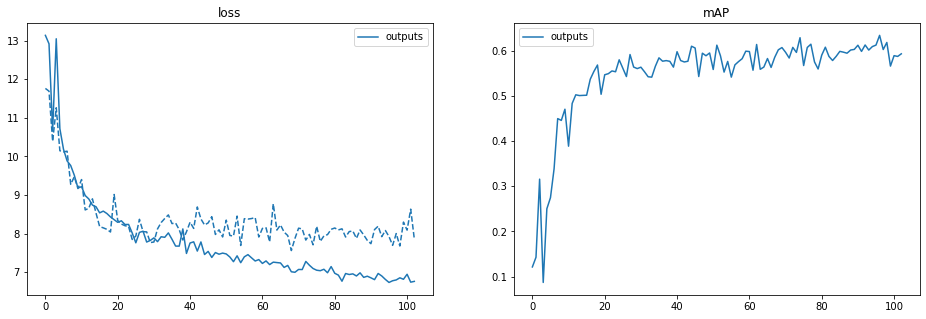

In [44]:
# Plot training curves
import seaborn
from util.plot_utils import plot_logs
from pathlib import Path
log_directory = [Path('outputs/')]

fields_of_interest = ('loss', 'mAP')
plot_logs(log_directory, fields_of_interest)

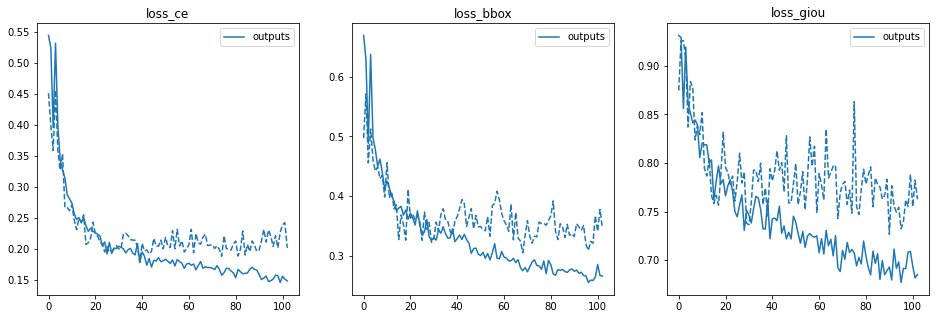

In [45]:
fields_of_interest = ('loss_ce', 'loss_bbox', 'loss_giou')
plot_logs(log_directory, fields_of_interest)

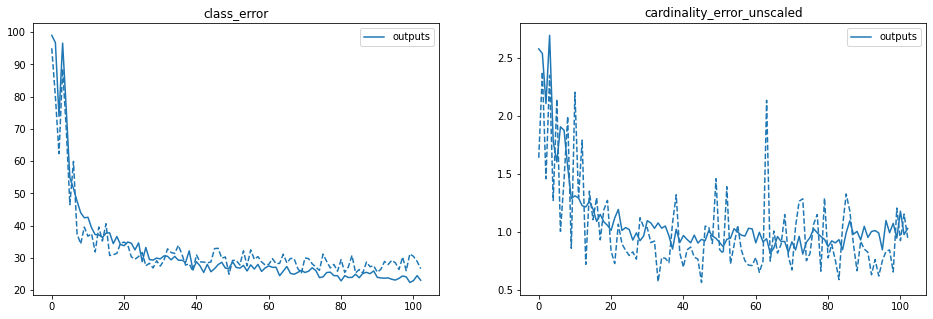

In [46]:
fields_of_interest = ('class_error', 'cardinality_error_unscaled')
plot_logs(log_directory, fields_of_interest)   

In [76]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=num_classes)
checkpoint = torch.load('outputs/checkpoint.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
model.eval();

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
    
def run_workflow(my_image, my_model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)
    for threshold in [0.9, 0.45]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
        print(f'probas {probas_to_keep}, bboxes {bboxes_scaled}')
        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)


Using cache found in /home/user/.cache/torch/hub/facebookresearch_detr_master


probas tensor([[2.6162e-09, 9.9423e-01, 3.4900e-05, 5.7438e-05],
        [7.4839e-09, 9.9676e-01, 3.9276e-04, 1.0524e-04],
        [3.2130e-08, 9.7520e-01, 6.2611e-04, 2.3521e-04],
        [9.3803e-09, 9.5968e-01, 1.4483e-04, 9.8097e-05]]), bboxes tensor([[248.7349, 335.0488, 603.3618, 715.0603],
        [  2.6941, 460.7803, 164.0401, 694.2379],
        [571.1567, 652.3032, 694.2961, 761.7612],
        [615.6887, 380.1562, 898.2210, 607.3058]])


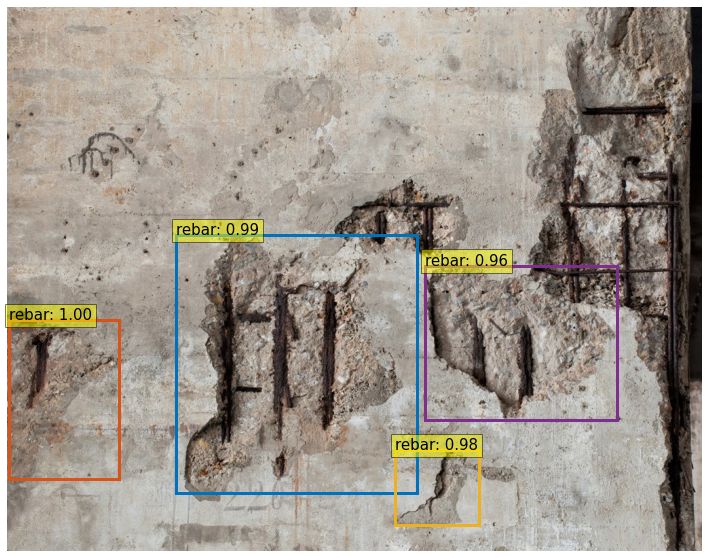

probas tensor([[7.3671e-09, 6.0162e-01, 5.3935e-04, 8.2290e-05],
        [9.4756e-09, 5.1200e-01, 4.6232e-04, 6.3600e-05],
        [1.1887e-08, 6.2775e-01, 1.5284e-03, 1.4517e-04],
        [8.0249e-09, 4.6806e-01, 5.0136e-04, 1.6930e-04],
        [1.2035e-08, 6.9178e-01, 4.9848e-04, 1.5726e-04],
        [1.3336e-08, 5.8588e-01, 7.0322e-04, 1.6468e-04],
        [6.8084e-09, 8.7985e-01, 1.4433e-04, 3.0625e-05],
        [3.0184e-08, 4.7306e-01, 4.6333e-04, 7.0192e-04],
        [2.6162e-09, 9.9423e-01, 3.4900e-05, 5.7438e-05],
        [7.4839e-09, 9.9676e-01, 3.9276e-04, 1.0524e-04],
        [8.4487e-09, 7.7778e-01, 2.6024e-04, 1.5333e-04],
        [3.2130e-08, 9.7520e-01, 6.2611e-04, 2.3521e-04],
        [9.3803e-09, 9.5968e-01, 1.4483e-04, 9.8097e-05],
        [7.2172e-09, 5.9351e-01, 6.8878e-04, 9.7540e-05],
        [1.1729e-08, 5.3671e-01, 3.3510e-04, 7.3004e-05],
        [8.8627e-09, 6.3086e-01, 4.2188e-04, 1.2099e-04]]), bboxes tensor([[  43.1002,  626.7963,   69.5937,  658.2670],
  

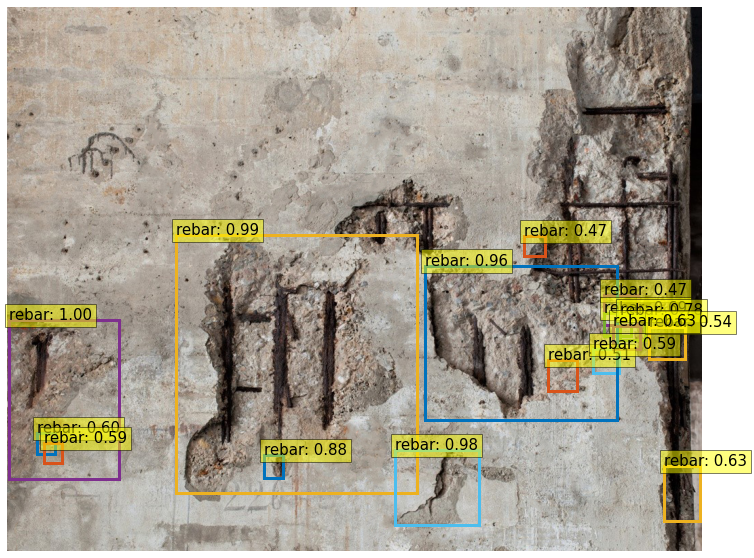

In [77]:
## with training image
im = Image.open('/media/App/tsai/capstone/val/00333.jpg')
run_workflow(im, model)